# Combo Sci-Plex training (with RDKit Embeddings) demo Notebook

In this notebook, we train CPA on the Combo Sci-Plex dataset using RDKit embeddings extracted with rdkit python package. The performance of the model finally has been evaluated on the test (OOD) set.

In [1]:
import sys
#if branch is stable, will install via pypi, else will install from source
branch = "stable"
IN_COLAB = "google.colab" in sys.modules

if IN_COLAB and branch == "stable":
    !pip install cpa-tools
elif IN_COLAB and branch != "stable":
    !pip install --quiet --upgrade jsonschema
    !pip install --quiet git+https://github.com/theislab/cpa

In [2]:
from sklearn.metrics import r2_score
import numpy as np

import os
# os.chdir('/home/mohsen/projects/cpa/') # For local run
# os.environ['CUDA_VISIBLE_DEVICES'] = '0' # For dedicated GPU usage

Import CPA package

In [3]:
import cpa
import scanpy as sc

Global seed set to 0


In [4]:
sc.settings.set_figure_params(dpi=100)

In [5]:
data_path = '/home/mohsen/projects/cpa/datasets/combo_sciplex_prep_hvg_filtered.h5ad'

## Data Loading

Combo sciplex dataset can be loaded using scanpy's read function. The dataset is already preprocessed and stored in the data folder. The following columns in `adata.obs` are required for training the model:

- `condition_ID`: Single/Combinatorial CHEMBL IDs of the drugs applied to the cells
- `log_dose`: Log-transformed dosages of the drugs applied to the cells
- `cell_type`: Cell types of the cells (All A549 in this case)
- `smiles_rkdit`: Canonical SMILES representation of the drugs separated by ".." for combinatorial perturbations
- `cov_drug_dose`: Covariates+Drug+Dosage information of the drugs applied to the cells (used for accessing top DEGs from adata.uns['rank_genes_groups_cov'])
- `split_1ct_MEC`: Train/valid/ood split information of the cells

In [6]:
adata = sc.read(data_path, backup_url='https://drive.google.com/uc?export=download&id=1RRV0_qYKGTvD3oCklKfoZQFYqKJy4l6t')
adata

AnnData object with n_obs × n_vars = 63378 × 5000
    obs: 'ncounts', 'well', 'plate', 'cell_line', 'replicate', 'time', 'dose_value', 'pathway1', 'pathway2', 'perturbation', 'target', 'pathway', 'dose_unit', 'celltype', 'disease', 'tissue_type', 'organism', 'perturbation_type', 'ngenes', 'percent_mito', 'percent_ribo', 'nperts', 'chembl-ID', 'condition', 'condition_ID', 'control', 'cell_type', 'smiles_rdkit', 'source', 'sample', 'Size_Factor', 'n.umi', 'RT_well', 'Drug1', 'Drug2', 'Well', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden', 'split', 'condition_old', 'pert_type', 'batch', 'split_1ct_MEC', 'split_2ct_MEC', 'split_3ct_MEC', 'batch_cov', 'batch_cov_cond', 'log_dose', 'cov_drug_dose'
    var: 'ensembl_id-0', 'ncounts-0', 'ncells-0', 'symbol-0', 'symbol-1', 'id-1', 'n_cells-1', 'mt-1', 'n_cells_by_counts-1', 'mean_counts-1', 'pct_dropout_by_counts-1', 'total_counts-1', 'highly_variable-1', 'means-1', 'dispersions-1', 'dispersions_nor

## Data preparation

__IMPORTANT__: Currenlty because of the standartized evaluation procedure, we need to provide adata.obs['control'] (0 if not control, 1 for cells to use as control). And we also need to provide de_genes in .uns['rank_genes_groups']. 

In [7]:
adata.obs['split_1ct_MEC'].value_counts()

train    49683
ood       8209
valid     5486
Name: split_1ct_MEC, dtype: int64

In the following, we will extract OOD drugs and visualize cells perturbed by them.

In [10]:
ood_conds = list(adata[adata.obs['split_1ct_MEC'] == 'ood'].obs['condition_ID'].value_counts().index)
ood_conds

['CHEMBL1213492+CHEMBL491473',
 'CHEMBL483254+CHEMBL4297436',
 'CHEMBL356066+CHEMBL402548',
 'CHEMBL483254+CHEMBL383824',
 'CHEMBL4297436+CHEMBL383824']

In [11]:
adata.obs['condition_split'] = adata.obs['condition_ID'].apply(lambda x: x if x in ood_conds else 'other')

In [12]:
sc.settings.verbosity = 3

In [13]:
sc.pp.neighbors(adata)
sc.tl.umap(adata)

computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:28)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:30)


In [15]:
sc.settings.set_figure_params(dpi=100)

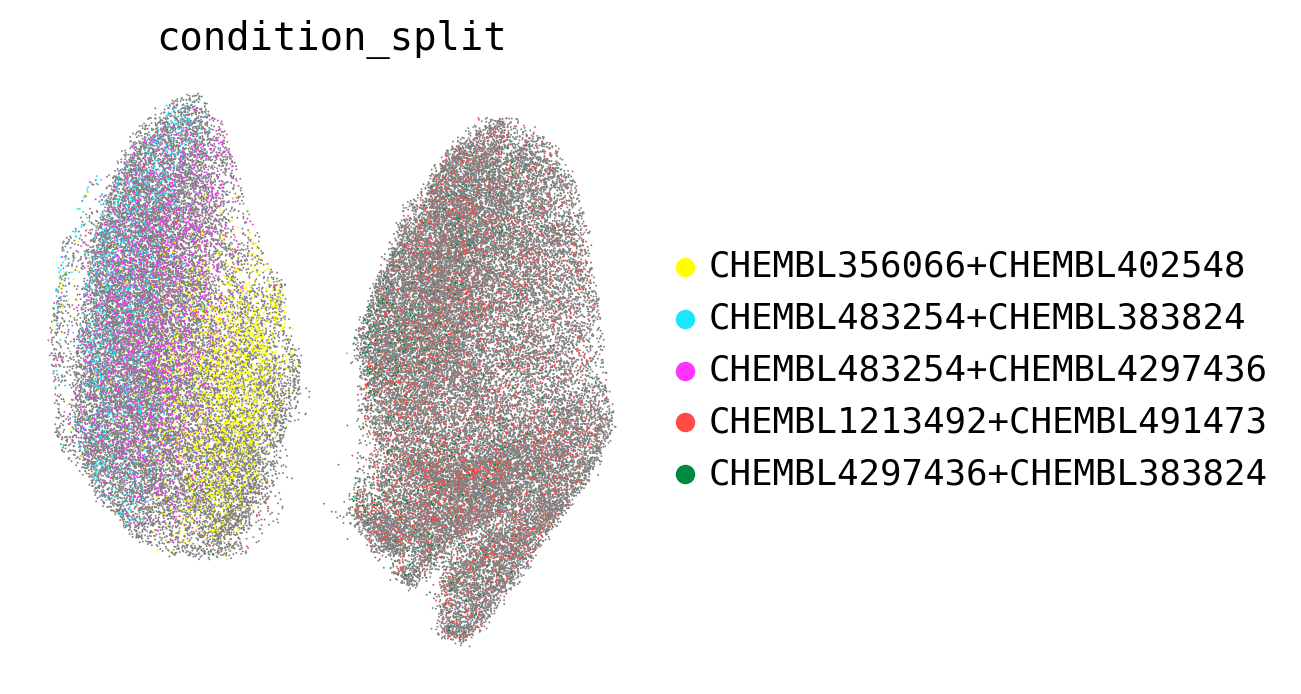

In [24]:
sc.pl.umap(adata, 
           color='condition_split', 
           groups=ood_conds, 
           palette=sc.pl.palettes.godsnot_102,
           na_in_legend=False,
           na_color='grey',
           frameon=False)

In [25]:
adata.X = adata.layers['counts'].copy()

## Data setup
Data setup is the first step required for training CPA. Just like scvi-tools models, you can call `cpa.CPA.setup_anndata` to preprocess your data. This function will accept the following arguments:

- `adata`: AnnData object containing the data to be preprocessed
- `perturbation_key`: The key in `adata.obs` that contains the perturbation information
- `control_group`: The name of the control group in `perturbation_key`
- `batch_key`: The key in `adata.obs` that contains the batch information
- `dosage_key`: The key in `adata.obs` that contains the dosage information
- `categorical_covariate_keys`: A list of keys in `adata.obs` that contain categorical covariates
- `is_count_data`: Whether the `adata.X` is count data or not
- `deg_uns_key`: The key in `adata.uns` that contains the differential expression results
- `deg_uns_cat_key`: The key in `adata.obs` that contains the category information of each cell which can be used as to access differential expression results in `adata.uns[deg_uns_key]`. For example, if `deg_uns_key` is `rank_genes_groups_cov` and `deg_uns_cat_key` is `cov_cond`, then `adata.uns[deg_uns_key][cov_cond]` will contain the differential expression results for each category in `cov_cond`.
- `max_comb_len`: The maximum number of perturbations that are applied to each cell. For example, if `max_comb_len` is 2, then the model will be trained to predict the effect of single perturbations and the effect of double perturbations.

In [9]:
cpa.CPA.setup_anndata(adata, 
                      perturbation_key='condition_ID',
                      dosage_key='log_dose',
                      control_group='CHEMBL504',
                      batch_key=None,
                      smiles_key='smiles_rdkit',
                      is_count_data=True,
                      categorical_covariate_keys=['cell_type'],
                      deg_uns_key='rank_genes_groups_cov',
                      deg_uns_cat_key='cov_drug_dose',
                      max_comb_len=2,
                     )

100%|███████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 1246.29it/s]
No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


INFO     Generating sequential column names                                                                        
INFO     Generating sequential column names                                                                        
INFO     Generating sequential column names                                                                        
INFO     Generating sequential column names                                                                        


## Training CPA

You can specify all the parameters for the model in a dictionary of parameters. If they are not specified, default values will be selected.

* `ae_hparams` are technical parameters of the architecture of the autoencoder.
    * `n_latent`: number of latent dimensions for the autoencoder
    * `recon_loss`: the type of reconstruction loss function to use
    * `doser_type`: the type of doser to use
    * `n_hidden_encoder`: number of hidden neurons in each hidden layer of the encoder
    * `n_layers_encoder`: number of hidden layers in the encoder
    * `n_hidden_decoder`: number of hidden neurons in each hidden layer of the decoder
    * `n_layers_decoder`: number of hidden layers in the decoder
    * `use_batch_norm_encoder`: if `True`, batch normalization will be used in the encoder
    * `use_layer_norm_encoder`: if `True`, layer normalization will be used in the encoder
    * `use_batch_norm_decoder`: if `True`, batch normalization will be used in the decoder
    * `use_layer_norm_decoder`: if `True`, layer normalization will be used in the decoder
    * `dropout_rate_encoder`: dropout rate used in the encoder
    * `dropout_rate_decoder`: dropout rate used in the decoder
    * `variational`: if `True`, variational autoencoder will be employed as the main perturbation response predictor
    * `seed`: number for setting the seed for generating random numbers.
* `trainer_params` are training parameters of CPA.
    * `n_epochs_adv_warmup`: number of epochs for adversarial warmup
    * `n_epochs_kl_warmup`: number of epochs for KL divergence warmup
    * `n_epochs_pretrain_ae`: number of epochs to pre-train the autoencoder
    * `adv_steps`: number of steps used to train adversarial classifiers after a single step of training the autoencoder
    * `mixup_alpha`: mixup interpolation coefficient
    * `n_epochs_mixup_warmup`: number of epochs for mixup warmup
    * `lr`: learning rate of the trainer
    * `wd`: weight decay of the trainer
    * `doser_lr`: learning rate of doser parameters
    * `doser_wd`: weight decay of doser parameters
    * `adv_lr`: learning rate of adversarial classifiers
    * `adv_wd`: weight decay rate of adversarial classifiers
    * `pen_adv`: penalty for adversarial classifiers
    * `reg_adv`: regularization for adversarial classifiers
    * `n_layers_adv`: number of hidden layers in adversarial classifiers
    * `n_hidden_adv`: number of hidden neurons in each hidden layer of adversarial classifiers
    * `use_batch_norm_adv`: if `True`, batch normalization will be used in the adversarial classifiers
    * `use_layer_norm_adv`: if `True`, layer normalization will be used in the adversarial classifiers
    * `dropout_rate_adv`: dropout rate used in the adversarial classifiers
    * `step_size_lr`: learning rate step size
    * `do_clip_grad`: if `True`, gradient clipping will be used
    * `adv_loss`: the type of loss function to use for adversarial training
    * `gradient_clip_value`: value to clip gradients to, if `do_clip_grad` is `True`

In [10]:
ae_hparams = {'n_latent': 64,
 'recon_loss': 'nb',
 'doser_type': 'linear',
 'n_hidden_encoder': 256,
 'n_layers_encoder': 3,
 'n_hidden_decoder': 512,
 'n_layers_decoder': 2,
 'use_batch_norm_encoder': True,
 'use_layer_norm_encoder': False,
 'use_batch_norm_decoder': True,
 'use_layer_norm_decoder': False,
 'dropout_rate_encoder': 0.25,
 'dropout_rate_decoder': 0.25,
 'variational': False,
 'seed': 6478}

trainer_params = {'n_epochs_kl_warmup': None,
 'n_epochs_pretrain_ae': 50,
 'n_epochs_adv_warmup': 100,
 'n_epochs_mixup_warmup': 10,
 'mixup_alpha': 0.1,
 'adv_steps': None,
 'n_hidden_adv': 128,
 'n_layers_adv': 3,
 'use_batch_norm_adv': False,
 'use_layer_norm_adv': False,
 'dropout_rate_adv': 0.2,
 'reg_adv': 10.0,
 'pen_adv': 0.1,
 'lr': 0.0003,
 'wd': 4e-07,
 'adv_lr': 0.0003,
 'adv_wd': 4e-07,
 'adv_loss': 'cce',
 'doser_lr': 0.0003,
 'doser_wd': 4e-07,
 'do_clip_grad': False,
 'gradient_clip_value': 1.0,
 'step_size_lr': 10}

## Model instantiation

__NOTE__: Run the following 3 cells if you haven't already trained CPA from scratch.

Here, we create a CPA model using `cpa.CPA` given all hyper-parameters.

In [11]:
adata.obs['split_1ct_MEC'].value_counts()

train    49683
ood       8209
valid     5486
Name: split_1ct_MEC, dtype: int64

In [12]:
model = cpa.CPA(adata=adata, 
                split_key='split_1ct_MEC',
                train_split='train',
                valid_split='valid',
                test_split='ood',
                use_rdkit_embeddings=True,
                **ae_hparams,
               )

Global seed set to 6478


(18, 2048)


## Training CPA

After creating a CPA object, we train the model with the following arguments:
* `max_epochs`: Maximum number of epochs to train the models.
* `use_gpu`: If `True`, will use the available GPU to train the model.
* `batch_size`: Number of samples to use in each mini-batches.
* `early_stopping_patience`: Number of epochs with no improvement in early stopping callback.
* `check_val_every_n_epoch`: Interval of checking validation losses.
* `save_path`: Path to save the model after the training has finished.

In [13]:
model.train(max_epochs=2000,
            use_gpu=True, 
            batch_size=512,
            plan_kwargs=trainer_params,
            early_stopping_patience=10,
            check_val_every_n_epoch=5,
            save_path='/home/mohsen/projects/cpa/lightning_logs/combo_rdkit/',
           )

100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 54.40it/s]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA RTX A6000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 5/2000:   0%|         | 4/2000 [01:10<11:14:26, 20.27s/it, v_num=1, recon=1.33e+3, r2_mean=0.904, adv_loss=2.25, acc_pert=0.171]


Epoch 00004: cpa_metric reached. Module best state updated.


Epoch 10/2000:   0%| | 9/2000 [03:10<11:32:22, 20.87s/it, v_num=1, recon=1.32e+3, r2_mean=0.912, adv_loss=2.12, acc_pert=0.192, val_re


Epoch 00009: cpa_metric reached. Module best state updated.



disnt_basal = 0.10935998205906987
disnt_after = 0.1947580928900672
val_r2_mean = 0.9087304059503858
val_r2_var = 0.5239273883678295
Epoch 15/2000:   1%| | 14/2000 [03:49<5:23:20,  9.77s/it, v_num=1, recon=1.31e+3, r2_mean=0.912, adv_loss=2.08, acc_pert=0.217, val_re


Epoch 00014: cpa_metric reached. Module best state updated.


Epoch 20/2000:   1%| | 19/2000 [04:29<4:31:19,  8.22s/it, v_num=1, recon=1.3e+3, r2_mean=0.915, adv_loss=2.07, acc_pert=0.228, val_rec


Epoch 00019: cpa_metric reached. Module best state updated.



disnt_basal = 0.09836006051939437
disnt_after = 0.20331588620822566
val_r2_mean = 0.9018172625740771
val_r2_var = 0.5401924108013962
Epoch 25/2000:   1%| | 24/2000 [05:10<4:23:27,  8.00s/it, v_num=1, recon=1.29e+3, r2_mean=0.915, adv_loss=2.1, acc_pert=0.222, val_rec


Epoch 00024: cpa_metric reached. Module best state updated.


Epoch 30/2000:   1%| | 29/2000 [05:47<4:02:34,  7.38s/it, v_num=1, recon=1.29e+3, r2_mean=0.916, adv_loss=2.14, acc_pert=0.218, val_re


Epoch 00029: cpa_metric reached. Module best state updated.



disnt_basal = 0.08712921352109765
disnt_after = 0.2052801964435556
val_r2_mean = 0.9123962264671068
val_r2_var = 0.5435857327297481
Epoch 35/2000:   2%| | 34/2000 [06:27<4:16:16,  7.82s/it, v_num=1, recon=1.29e+3, r2_mean=0.915, adv_loss=2.19, acc_pert=0.215, val_re


Epoch 00034: cpa_metric reached. Module best state updated.


Epoch 40/2000:   2%| | 39/2000 [07:05<4:03:35,  7.45s/it, v_num=1, recon=1.28e+3, r2_mean=0.917, adv_loss=2.22, acc_pert=0.212, val_re
disnt_basal = 0.07843184176780146
disnt_after = 0.20770758128973216
val_r2_mean = 0.9067388287297002
val_r2_var = 0.5569063208319924
Epoch 45/2000:   2%| | 44/2000 [07:46<4:21:04,  8.01s/it, v_num=1, recon=1.28e+3, r2_mean=0.916, adv_loss=2.26, acc_pert=0.205, val_re


Epoch 00044: cpa_metric reached. Module best state updated.


Epoch 50/2000:   2%| | 49/2000 [08:25<4:04:41,  7.53s/it, v_num=1, recon=1.28e+3, r2_mean=0.917, adv_loss=2.31, acc_pert=0.198, val_re


Epoch 00049: cpa_metric reached. Module best state updated.



disnt_basal = 0.07375605171504182
disnt_after = 0.22323710480713033
val_r2_mean = 0.9130540171054878
val_r2_var = 0.5530647197957793
Epoch 55/2000:   3%| | 54/2000 [09:05<4:19:32,  8.00s/it, v_num=1, recon=1.27e+3, r2_mean=0.918, adv_loss=2.47, acc_pert=0.181, val_re


Epoch 00054: cpa_metric reached. Module best state updated.


Epoch 60/2000:   3%| | 59/2000 [09:50<4:33:56,  8.47s/it, v_num=1, recon=1.27e+3, r2_mean=0.919, adv_loss=2.67, acc_pert=0.152, val_re


Epoch 00059: cpa_metric reached. Module best state updated.



disnt_basal = 0.06024990624800466
disnt_after = 0.21984197099233702
val_r2_mean = 0.9087773384871306
val_r2_var = 0.5638583727958628
Epoch 65/2000:   3%| | 64/2000 [10:34<4:42:46,  8.76s/it, v_num=1, recon=1.27e+3, r2_mean=0.918, adv_loss=2.84, acc_pert=0.125, val_re


Epoch 00064: cpa_metric reached. Module best state updated.


Epoch 70/2000:   3%| | 69/2000 [11:20<4:46:58,  8.92s/it, v_num=1, recon=1.27e+3, r2_mean=0.919, adv_loss=2.94, acc_pert=0.112, val_re


Epoch 00069: cpa_metric reached. Module best state updated.



disnt_basal = 0.05042097894349415
disnt_after = 0.2285000618741189
val_r2_mean = 0.904481914509025
val_r2_var = 0.5684133487117009
Epoch 75/2000:   4%| | 74/2000 [12:07<4:53:52,  9.16s/it, v_num=1, recon=1.27e+3, r2_mean=0.918, adv_loss=3.01, acc_pert=0.101, val_re


Epoch 00074: cpa_metric reached. Module best state updated.


Epoch 80/2000:   4%| | 79/2000 [12:53<4:47:11,  8.97s/it, v_num=1, recon=1.26e+3, r2_mean=0.919, adv_loss=3.06, acc_pert=0.0929, val_r


Epoch 00079: cpa_metric reached. Module best state updated.



disnt_basal = 0.04626068302570279
disnt_after = 0.2414682926452566
val_r2_mean = 0.90780227653908
val_r2_var = 0.563313795460595
Epoch 85/2000:   4%| | 84/2000 [13:38<4:38:39,  8.73s/it, v_num=1, recon=1.26e+3, r2_mean=0.919, adv_loss=3.08, acc_pert=0.0874, val_r


Epoch 00084: cpa_metric reached. Module best state updated.


Epoch 90/2000:   4%| | 89/2000 [14:23<4:46:46,  9.00s/it, v_num=1, recon=1.26e+3, r2_mean=0.918, adv_loss=3.11, acc_pert=0.0841, val_r


Epoch 00089: cpa_metric reached. Module best state updated.



disnt_basal = 0.04528630029442043
disnt_after = 0.25225609797660486
val_r2_mean = 0.9069772950727931
val_r2_var = 0.5681825789939675
Epoch 95/2000:   5%| | 94/2000 [15:10<4:56:06,  9.32s/it, v_num=1, recon=1.26e+3, r2_mean=0.919, adv_loss=3.13, acc_pert=0.0783, val_r


Epoch 00094: cpa_metric reached. Module best state updated.


Epoch 100/2000:   5%| | 99/2000 [15:54<4:40:07,  8.84s/it, v_num=1, recon=1.26e+3, r2_mean=0.919, adv_loss=3.15, acc_pert=0.0771, val_


Epoch 00099: cpa_metric reached. Module best state updated.



disnt_basal = 0.04494676974137365
disnt_after = 0.26197003263361773
val_r2_mean = 0.9158698047451701
val_r2_var = 0.5516319541818766
Epoch 105/2000:   5%| | 104/2000 [16:40<4:44:37,  9.01s/it, v_num=1, recon=1.26e+3, r2_mean=0.92, adv_loss=3.16, acc_pert=0.0744, val_


Epoch 00104: cpa_metric reached. Module best state updated.


Epoch 110/2000:   5%| | 109/2000 [17:30<5:01:15,  9.56s/it, v_num=1, recon=1.26e+3, r2_mean=0.919, adv_loss=3.17, acc_pert=0.0696, val
disnt_basal = 0.04339071490366559
disnt_after = 0.2604380221300531
val_r2_mean = 0.9125259323954983
val_r2_var = 0.5690988555099025
Epoch 115/2000:   6%| | 114/2000 [18:15<4:47:45,  9.15s/it, v_num=1, recon=1.26e+3, r2_mean=0.918, adv_loss=3.18, acc_pert=0.0698, val


Epoch 00114: cpa_metric reached. Module best state updated.


Epoch 120/2000:   6%| | 119/2000 [19:04<4:58:09,  9.51s/it, v_num=1, recon=1.26e+3, r2_mean=0.921, adv_loss=3.19, acc_pert=0.0673, val


Epoch 00119: cpa_metric reached. Module best state updated.



disnt_basal = 0.04304725258172981
disnt_after = 0.27402960880763183
val_r2_mean = 0.9129360739630883
val_r2_var = 0.5630708128113538
Epoch 125/2000:   6%| | 124/2000 [19:50<4:46:14,  9.16s/it, v_num=1, recon=1.26e+3, r2_mean=0.921, adv_loss=3.19, acc_pert=0.0665, val


Epoch 00124: cpa_metric reached. Module best state updated.


Epoch 130/2000:   6%| | 129/2000 [20:35<4:37:01,  8.88s/it, v_num=1, recon=1.26e+3, r2_mean=0.919, adv_loss=3.2, acc_pert=0.0651, val_


Epoch 00129: cpa_metric reached. Module best state updated.



disnt_basal = 0.04174844759476427
disnt_after = 0.28627420062442704
val_r2_mean = 0.9105156136281564
val_r2_var = 0.5637243307800806
Epoch 140/2000:   7%| | 139/2000 [22:02<4:23:46,  8.50s/it, v_num=1, recon=1.26e+3, r2_mean=0.92, adv_loss=3.21, acc_pert=0.0621, val_
disnt_basal = 0.04217145517764959
disnt_after = 0.2805999259742059
val_r2_mean = 0.9146810872386198
val_r2_var = 0.5651895538323655
Epoch 145/2000:   7%| | 144/2000 [22:43<4:14:15,  8.22s/it, v_num=1, recon=1.25e+3, r2_mean=0.92, adv_loss=3.22, acc_pert=0.061, val_r


Epoch 00144: cpa_metric reached. Module best state updated.


Epoch 150/2000:   7%| | 149/2000 [23:28<4:29:36,  8.74s/it, v_num=1, recon=1.25e+3, r2_mean=0.921, adv_loss=3.22, acc_pert=0.0607, val


Epoch 00149: cpa_metric reached. Module best state updated.



disnt_basal = 0.04115490579605907
disnt_after = 0.30270976116181003
val_r2_mean = 0.9097078623193684
val_r2_var = 0.5575797549803249
Epoch 155/2000:   8%| | 154/2000 [24:10<4:13:55,  8.25s/it, v_num=1, recon=1.25e+3, r2_mean=0.92, adv_loss=3.22, acc_pert=0.0594, val_


Epoch 00154: cpa_metric reached. Module best state updated.


Epoch 160/2000:   8%| | 159/2000 [24:55<4:27:57,  8.73s/it, v_num=1, recon=1.25e+3, r2_mean=0.921, adv_loss=3.23, acc_pert=0.0601, val


Epoch 00159: cpa_metric reached. Module best state updated.



disnt_basal = 0.041702075277698675
disnt_after = 0.30185033605274075
val_r2_mean = 0.9131247589885184
val_r2_var = 0.5600758447791591
Epoch 165/2000:   8%| | 164/2000 [25:36<4:05:18,  8.02s/it, v_num=1, recon=1.25e+3, r2_mean=0.921, adv_loss=3.23, acc_pert=0.0592, val


Epoch 00164: cpa_metric reached. Module best state updated.


Epoch 170/2000:   8%| | 169/2000 [26:18<4:14:26,  8.34s/it, v_num=1, recon=1.25e+3, r2_mean=0.921, adv_loss=3.23, acc_pert=0.0582, val


Epoch 00169: cpa_metric reached. Module best state updated.



disnt_basal = 0.04054660772157918
disnt_after = 0.30944831027394487
val_r2_mean = 0.9047880594176476
val_r2_var = 0.5663980542609989
Epoch 175/2000:   9%| | 174/2000 [27:41<9:27:12, 18.64s/it, v_num=1, recon=1.25e+3, r2_mean=0.92, adv_loss=3.23, acc_pert=0.0568, val_


Epoch 00174: cpa_metric reached. Module best state updated.


Epoch 180/2000:   9%| | 179/2000 [29:28<9:23:10, 18.56s/it, v_num=1, recon=1.25e+3, r2_mean=0.92, adv_loss=3.23, acc_pert=0.0579, val_


Epoch 00179: cpa_metric reached. Module best state updated.



disnt_basal = 0.04031620204251352
disnt_after = 0.31916067204719945
val_r2_mean = 0.9093311804312246
val_r2_var = 0.5613407139424924
Epoch 185/2000:   9%| | 184/2000 [30:16<5:36:17, 11.11s/it, v_num=1, recon=1.25e+3, r2_mean=0.921, adv_loss=3.23, acc_pert=0.0575, val


Epoch 00184: cpa_metric reached. Module best state updated.


Epoch 190/2000:   9%| | 189/2000 [31:04<4:53:26,  9.72s/it, v_num=1, recon=1.25e+3, r2_mean=0.922, adv_loss=3.23, acc_pert=0.0579, val


Epoch 00189: cpa_metric reached. Module best state updated.



disnt_basal = 0.04147435332487317
disnt_after = 0.32289914177116436
val_r2_mean = 0.9104435285333833
val_r2_var = 0.5612664056145383
Epoch 195/2000:  10%| | 194/2000 [31:51<4:46:24,  9.52s/it, v_num=1, recon=1.25e+3, r2_mean=0.92, adv_loss=3.23, acc_pert=0.0573, val_


Epoch 00194: cpa_metric reached. Module best state updated.


Epoch 200/2000:  10%| | 199/2000 [32:38<4:39:35,  9.31s/it, v_num=1, recon=1.25e+3, r2_mean=0.92, adv_loss=3.23, acc_pert=0.057, val_r


Epoch 00199: cpa_metric reached. Module best state updated.



disnt_basal = 0.04115023126718784
disnt_after = 0.33321823779642357
val_r2_mean = 0.908866039731286
val_r2_var = 0.558030357959202
Epoch 205/2000:  10%| | 204/2000 [33:25<4:38:22,  9.30s/it, v_num=1, recon=1.25e+3, r2_mean=0.921, adv_loss=3.23, acc_pert=0.0573, val


Epoch 00204: cpa_metric reached. Module best state updated.


Epoch 210/2000:  10%| | 209/2000 [34:54<9:26:02, 18.96s/it, v_num=1, recon=1.25e+3, r2_mean=0.922, adv_loss=3.23, acc_pert=0.0567, val
disnt_basal = 0.04024653138473878
disnt_after = 0.33018913026085883
val_r2_mean = 0.9091093530157198
val_r2_var = 0.5620534755164124
Epoch 215/2000:  11%| | 214/2000 [36:55<9:29:23, 19.13s/it, v_num=1, recon=1.25e+3, r2_mean=0.921, adv_loss=3.23, acc_pert=0.0559, val


Epoch 00214: cpa_metric reached. Module best state updated.


Epoch 220/2000:  11%| | 219/2000 [37:42<5:18:25, 10.73s/it, v_num=1, recon=1.25e+3, r2_mean=0.922, adv_loss=3.24, acc_pert=0.0555, val
disnt_basal = 0.04064928305878278
disnt_after = 0.332652966633433
val_r2_mean = 0.9123359880463443
val_r2_var = 0.5672176745202807
Epoch 225/2000:  11%| | 224/2000 [38:33<5:00:35, 10.16s/it, v_num=1, recon=1.25e+3, r2_mean=0.92, adv_loss=3.23, acc_pert=0.0568, val_


Epoch 00224: cpa_metric reached. Module best state updated.


Epoch 230/2000:  11%| | 229/2000 [39:24<5:03:03, 10.27s/it, v_num=1, recon=1.25e+3, r2_mean=0.92, adv_loss=3.24, acc_pert=0.0566, val_
disnt_basal = 0.04036115876415716
disnt_after = 0.3378564856058243
val_r2_mean = 0.910251923683115
val_r2_var = 0.566620121098528
Epoch 240/2000:  12%| | 239/2000 [41:00<4:30:41,  9.22s/it, v_num=1, recon=1.25e+3, r2_mean=0.92, adv_loss=3.23, acc_pert=0.0564, val_
disnt_basal = 0.04045372147394693
disnt_after = 0.34173993593466334
val_r2_mean = 0.9095593357728387
val_r2_var = 0.5628890019875986
Epoch 245/2000:  12%| | 244/2000 [41:47<4:32:58,  9.33s/it, v_num=1, recon=1.25e+3, r2_mean=0.92, adv_loss=3.23, acc_pert=0.0553, val_


Epoch 00244: cpa_metric reached. Module best state updated.


Epoch 250/2000:  12%| | 249/2000 [42:31<4:18:21,  8.85s/it, v_num=1, recon=1.25e+3, r2_mean=0.922, adv_loss=3.23, acc_pert=0.0561, val


Epoch 00249: cpa_metric reached. Module best state updated.



disnt_basal = 0.039513698714692805
disnt_after = 0.34576276899510144
val_r2_mean = 0.9027658825370198
val_r2_var = 0.5758106174693766
Epoch 255/2000:  13%|▏| 254/2000 [43:18<4:24:13,  9.08s/it, v_num=1, recon=1.25e+3, r2_mean=0.921, adv_loss=3.24, acc_pert=0.058, val_


Epoch 00254: cpa_metric reached. Module best state updated.


Epoch 260/2000:  13%|▏| 259/2000 [44:03<4:15:25,  8.80s/it, v_num=1, recon=1.25e+3, r2_mean=0.922, adv_loss=3.24, acc_pert=0.0575, val
disnt_basal = 0.03994983206016651
disnt_after = 0.3439185323833249
val_r2_mean = 0.910643367052881
val_r2_var = 0.5654164647012447
Epoch 265/2000:  13%|▏| 264/2000 [44:46<4:03:03,  8.40s/it, v_num=1, recon=1.25e+3, r2_mean=0.92, adv_loss=3.24, acc_pert=0.0558, val_


Epoch 00264: cpa_metric reached. Module best state updated.


Epoch 270/2000:  13%|▏| 269/2000 [45:31<4:12:00,  8.74s/it, v_num=1, recon=1.25e+3, r2_mean=0.921, adv_loss=3.24, acc_pert=0.0566, val
disnt_basal = 0.040166761968135005
disnt_after = 0.3504748097196458
val_r2_mean = 0.9097813715035666
val_r2_var = 0.5645362028369197
Epoch 275/2000:  14%|▏| 274/2000 [46:17<4:21:53,  9.10s/it, v_num=1, recon=1.25e+3, r2_mean=0.921, adv_loss=3.24, acc_pert=0.057, val_


Epoch 00274: cpa_metric reached. Module best state updated.


Epoch 280/2000:  14%|▏| 279/2000 [47:00<4:07:23,  8.63s/it, v_num=1, recon=1.25e+3, r2_mean=0.921, adv_loss=3.24, acc_pert=0.0553, val


Epoch 00279: cpa_metric reached. Module best state updated.



disnt_basal = 0.040456163244333036
disnt_after = 0.3572522499600077
val_r2_mean = 0.910852282336264
val_r2_var = 0.5594399948714157
Epoch 285/2000:  14%|▏| 284/2000 [47:48<4:30:46,  9.47s/it, v_num=1, recon=1.25e+3, r2_mean=0.921, adv_loss=3.24, acc_pert=0.0576, val


Epoch 00284: cpa_metric reached. Module best state updated.


Epoch 290/2000:  14%|▏| 289/2000 [48:35<4:22:33,  9.21s/it, v_num=1, recon=1.25e+3, r2_mean=0.921, adv_loss=3.24, acc_pert=0.0559, val
disnt_basal = 0.03926832712372904
disnt_after = 0.3497102540936567
val_r2_mean = 0.9121499475003894
val_r2_var = 0.570735256479244
Epoch 295/2000:  15%|▏| 294/2000 [49:22<4:21:00,  9.18s/it, v_num=1, recon=1.25e+3, r2_mean=0.921, adv_loss=3.24, acc_pert=0.0551, val


Epoch 00294: cpa_metric reached. Module best state updated.


Epoch 300/2000:  15%|▏| 299/2000 [50:09<4:30:07,  9.53s/it, v_num=1, recon=1.25e+3, r2_mean=0.92, adv_loss=3.23, acc_pert=0.0568, val_


Epoch 00299: cpa_metric reached. Module best state updated.



disnt_basal = 0.03920168682453528
disnt_after = 0.36158794127635674
val_r2_mean = 0.9137285146818851
val_r2_var = 0.5629803686600774
Epoch 310/2000:  15%|▏| 309/2000 [52:19<5:36:45, 11.95s/it, v_num=1, recon=1.25e+3, r2_mean=0.921, adv_loss=3.24, acc_pert=0.0554, val


Epoch 00309: cpa_metric reached. Module best state updated.



disnt_basal = 0.03981924943625341
disnt_after = 0.3652186213880025
val_r2_mean = 0.9131556992177609
val_r2_var = 0.5631247309321908
Epoch 320/2000:  16%|▏| 319/2000 [53:49<4:05:29,  8.76s/it, v_num=1, recon=1.25e+3, r2_mean=0.921, adv_loss=3.24, acc_pert=0.0562, val


Epoch 00319: cpa_metric reached. Module best state updated.



disnt_basal = 0.04053643754989322
disnt_after = 0.37015536414977995
val_r2_mean = 0.9128284351994292
val_r2_var = 0.5662032074799843
Epoch 330/2000:  16%|▏| 329/2000 [55:20<4:13:39,  9.11s/it, v_num=1, recon=1.25e+3, r2_mean=0.92, adv_loss=3.24, acc_pert=0.0556, val_
disnt_basal = 0.040080655093989045
disnt_after = 0.3678346731429833
val_r2_mean = 0.9095952502806178
val_r2_var = 0.5599004443647083
Epoch 340/2000:  17%|▏| 339/2000 [56:49<4:05:14,  8.86s/it, v_num=1, recon=1.24e+3, r2_mean=0.921, adv_loss=3.23, acc_pert=0.0569, val
disnt_basal = 0.03988857249217172
disnt_after = 0.3704604220867891
val_r2_mean = 0.9106467877975618
val_r2_var = 0.5663637701509777
Epoch 345/2000:  17%|▏| 344/2000 [57:48<5:50:59, 12.72s/it, v_num=1, recon=1.24e+3, r2_mean=0.92, adv_loss=3.24, acc_pert=0.0557, val_


Epoch 00344: cpa_metric reached. Module best state updated.


Epoch 350/2000:  17%|▏| 349/2000 [58:36<4:47:45, 10.46s/it, v_num=1, recon=1.25e+3, r2_mean=0.921, adv_loss=3.24, acc_pert=0.0567, val
disnt_basal = 0.03922064593854288
disnt_after = 0.3690430275185857
val_r2_mean = 0.9116486545765038
val_r2_var = 0.5657429996162955
Epoch 360/2000:  18%|▏| 359/2000 [1:00:18<5:28:15, 12.00s/it, v_num=1, recon=1.25e+3, r2_mean=0.921, adv_loss=3.24, acc_pert=0.0553, v
disnt_basal = 0.0403999673155449
disnt_after = 0.3734554326820138
val_r2_mean = 0.913087622886555
val_r2_var = 0.5652885898596509
Epoch 365/2000:  18%|▏| 364/2000 [1:01:30<6:21:43, 14.00s/it, v_num=1, recon=1.25e+3, r2_mean=0.922, adv_loss=3.24, acc_pert=0.0558, v


Epoch 00364: cpa_metric reached. Module best state updated.


Epoch 370/2000:  18%|▏| 369/2000 [1:02:43<5:58:14, 13.18s/it, v_num=1, recon=1.24e+3, r2_mean=0.921, adv_loss=3.24, acc_pert=0.0576, v
disnt_basal = 0.040913813357305866
disnt_after = 0.37245901582466023
val_r2_mean = 0.9121225030735285
val_r2_var = 0.5635640514820112
Epoch 380/2000:  19%|▏| 379/2000 [1:07:00<12:46:45, 28.38s/it, v_num=1, recon=1.24e+3, r2_mean=0.921, adv_loss=3.24, acc_pert=0.0564, 


Epoch 00379: cpa_metric reached. Module best state updated.



disnt_basal = 0.039450868211319774
disnt_after = 0.3810250290713748
val_r2_mean = 0.9111390364691865
val_r2_var = 0.567552351791048
Epoch 390/2000:  19%|▏| 389/2000 [1:09:44<7:36:34, 17.00s/it, v_num=1, recon=1.24e+3, r2_mean=0.921, adv_loss=3.24, acc_pert=0.0565, v
disnt_basal = 0.039263429869721284
disnt_after = 0.37796660162953394
val_r2_mean = 0.9129030499100778
val_r2_var = 0.5679200446627295
Epoch 400/2000:  20%|▏| 399/2000 [1:11:17<4:32:52, 10.23s/it, v_num=1, recon=1.24e+3, r2_mean=0.921, adv_loss=3.24, acc_pert=0.056, va
disnt_basal = 0.039448362508479856
disnt_after = 0.38306228513894836
val_r2_mean = 0.9112247363084092
val_r2_var = 0.5607114321856386
Epoch 410/2000:  20%|▏| 409/2000 [1:13:29<5:08:16, 11.63s/it, v_num=1, recon=1.24e+3, r2_mean=0.922, adv_loss=3.24, acc_pert=0.0567, v


Epoch 00409: cpa_metric reached. Module best state updated.



disnt_basal = 0.040036109266303084
disnt_after = 0.3852261108922756
val_r2_mean = 0.9092650594133318
val_r2_var = 0.5641676907988912
Epoch 415/2000:  21%|▏| 414/2000 [1:14:38<6:46:17, 15.37s/it, v_num=1, recon=1.24e+3, r2_mean=0.922, adv_loss=3.24, acc_pert=0.0557, v


Epoch 00414: cpa_metric reached. Module best state updated.


Epoch 420/2000:  21%|▏| 419/2000 [1:15:31<5:35:45, 12.74s/it, v_num=1, recon=1.24e+3, r2_mean=0.921, adv_loss=3.24, acc_pert=0.0564, v


Epoch 00419: cpa_metric reached. Module best state updated.



disnt_basal = 0.03985408537328855
disnt_after = 0.38631324868336364
val_r2_mean = 0.9112534330348777
val_r2_var = 0.5670535080762021
Epoch 430/2000:  21%|▏| 429/2000 [1:17:30<6:08:04, 14.06s/it, v_num=1, recon=1.24e+3, r2_mean=0.92, adv_loss=3.24, acc_pert=0.0551, va
disnt_basal = 0.04051310007875685
disnt_after = 0.38639743931358783
val_r2_mean = 0.9099488471092197
val_r2_var = 0.5686952479760654
Epoch 440/2000:  22%|▏| 439/2000 [1:20:45<9:44:56, 22.48s/it, v_num=1, recon=1.24e+3, r2_mean=0.92, adv_loss=3.23, acc_pert=0.0559, va
disnt_basal = 0.03956727544223899
disnt_after = 0.3850694862411169
val_r2_mean = 0.9107194233823706
val_r2_var = 0.5699542847145286
Epoch 445/2000:  22%|▏| 444/2000 [1:22:10<7:22:45, 17.07s/it, v_num=1, recon=1.24e+3, r2_mean=0.922, adv_loss=3.24, acc_pert=0.0554, v


Epoch 00444: cpa_metric reached. Module best state updated.


Epoch 450/2000:  22%|▏| 449/2000 [1:22:46<3:45:54,  8.74s/it, v_num=1, recon=1.24e+3, r2_mean=0.922, adv_loss=3.24, acc_pert=0.056, va
disnt_basal = 0.04032557922243797
disnt_after = 0.3854489771448042
val_r2_mean = 0.9121489962343414
val_r2_var = 0.5680684710191155
Epoch 455/2000:  23%|▏| 454/2000 [1:23:21<3:04:32,  7.16s/it, v_num=1, recon=1.24e+3, r2_mean=0.921, adv_loss=3.24, acc_pert=0.0554, v


Epoch 00454: cpa_metric reached. Module best state updated.


Epoch 460/2000:  23%|▏| 459/2000 [1:23:58<3:08:30,  7.34s/it, v_num=1, recon=1.24e+3, r2_mean=0.921, adv_loss=3.24, acc_pert=0.0574, v


Epoch 00459: cpa_metric reached. Module best state updated.



disnt_basal = 0.04082144897444196
disnt_after = 0.393595290106351
val_r2_mean = 0.9105518125123045
val_r2_var = 0.5637211177485558
Epoch 470/2000:  23%|▏| 469/2000 [1:25:07<2:53:05,  6.78s/it, v_num=1, recon=1.24e+3, r2_mean=0.921, adv_loss=3.24, acc_pert=0.0554, v
disnt_basal = 0.04000654212230136
disnt_after = 0.39207859489413543
val_r2_mean = 0.9072011171366632
val_r2_var = 0.5625318035934911
Epoch 480/2000:  24%|▏| 479/2000 [1:26:16<2:55:48,  6.93s/it, v_num=1, recon=1.24e+3, r2_mean=0.922, adv_loss=3.24, acc_pert=0.0563, v
disnt_basal = 0.03941728266625964
disnt_after = 0.39080270029069025
val_r2_mean = 0.9118343844558254
val_r2_var = 0.563226621158998
Epoch 485/2000:  24%|▏| 484/2000 [1:26:53<3:00:19,  7.14s/it, v_num=1, recon=1.24e+3, r2_mean=0.922, adv_loss=3.24, acc_pert=0.0563, v


Epoch 00484: cpa_metric reached. Module best state updated.


Epoch 490/2000:  24%|▏| 489/2000 [1:27:29<2:59:15,  7.12s/it, v_num=1, recon=1.24e+3, r2_mean=0.921, adv_loss=3.24, acc_pert=0.0541, v


Epoch 00489: cpa_metric reached. Module best state updated.



disnt_basal = 0.03966032767287265
disnt_after = 0.3974854925612059
val_r2_mean = 0.9125428593118584
val_r2_var = 0.5673860899527065
Epoch 500/2000:  25%|▏| 499/2000 [1:28:41<2:55:01,  7.00s/it, v_num=1, recon=1.25e+3, r2_mean=0.922, adv_loss=3.24, acc_pert=0.0564, v


Epoch 00499: cpa_metric reached. Module best state updated.



disnt_basal = 0.04011059166043884
disnt_after = 0.40303497237209807
val_r2_mean = 0.9112178507986787
val_r2_var = 0.5679613636028455
Epoch 510/2000:  25%|▎| 509/2000 [1:29:50<2:52:34,  6.94s/it, v_num=1, recon=1.24e+3, r2_mean=0.921, adv_loss=3.24, acc_pert=0.0564, v
disnt_basal = 0.03966800904716618
disnt_after = 0.40238836002755796
val_r2_mean = 0.9136719005276458
val_r2_var = 0.5598738438352592
Epoch 520/2000:  26%|▎| 519/2000 [1:30:59<2:46:12,  6.73s/it, v_num=1, recon=1.24e+3, r2_mean=0.92, adv_loss=3.24, acc_pert=0.0539, va
disnt_basal = 0.03960290847682412
disnt_after = 0.4008921205035158
val_r2_mean = 0.9125659736719999
val_r2_var = 0.5624201327863366
Epoch 530/2000:  26%|▎| 529/2000 [1:32:09<2:52:51,  7.05s/it, v_num=1, recon=1.24e+3, r2_mean=0.922, adv_loss=3.24, acc_pert=0.0564, v
disnt_basal = 0.040439245104308234
disnt_after = 0.4026161051268289
val_r2_mean = 0.9085394224333843
val_r2_var = 0.5630331177904148
Epoch 540/2000:  27%|▎| 539/2000 [1:33:17<2:39:52,  6.57s/it, v


Epoch 00544: cpa_metric reached. Module best state updated.


Epoch 550/2000:  27%|▎| 549/2000 [1:34:26<2:43:00,  6.74s/it, v_num=1, recon=1.24e+3, r2_mean=0.921, adv_loss=3.24, acc_pert=0.0546, v
disnt_basal = 0.03915781291126416
disnt_after = 0.4030755817464731
val_r2_mean = 0.9123560565489309
val_r2_var = 0.5630666194138704
Epoch 560/2000:  28%|▎| 559/2000 [1:35:34<2:42:03,  6.75s/it, v_num=1, recon=1.24e+3, r2_mean=0.921, adv_loss=3.24, acc_pert=0.0566, v


Epoch 00559: cpa_metric reached. Module best state updated.



disnt_basal = 0.04046507063700886
disnt_after = 0.40739666400036006
val_r2_mean = 0.9103421920076363
val_r2_var = 0.5684774481888972
Epoch 570/2000:  28%|▎| 569/2000 [1:36:50<3:10:06,  7.97s/it, v_num=1, recon=1.24e+3, r2_mean=0.921, adv_loss=3.24, acc_pert=0.0541, v
disnt_basal = 0.03983058922661337
disnt_after = 0.4067729732602119
val_r2_mean = 0.9094641451482418
val_r2_var = 0.5637151167448923
Epoch 575/2000:  29%|▎| 574/2000 [1:37:25<2:50:54,  7.19s/it, v_num=1, recon=1.24e+3, r2_mean=0.921, adv_loss=3.24, acc_pert=0.0566, v


Epoch 00574: cpa_metric reached. Module best state updated.


Epoch 580/2000:  29%|▎| 579/2000 [1:38:01<2:49:19,  7.15s/it, v_num=1, recon=1.24e+3, r2_mean=0.922, adv_loss=3.24, acc_pert=0.0546, v
disnt_basal = 0.03989654234166392
disnt_after = 0.409478339726352
val_r2_mean = 0.9119101698551115
val_r2_var = 0.5607152105581882
Epoch 590/2000:  29%|▎| 589/2000 [1:39:12<2:39:40,  6.79s/it, v_num=1, recon=1.24e+3, r2_mean=0.922, adv_loss=3.24, acc_pert=0.0563, v


Epoch 00589: cpa_metric reached. Module best state updated.



disnt_basal = 0.04008174666683633
disnt_after = 0.4091380709161543
val_r2_mean = 0.9118934548663771
val_r2_var = 0.5687675744997531
Epoch 600/2000:  30%|▎| 599/2000 [1:40:21<2:36:38,  6.71s/it, v_num=1, recon=1.24e+3, r2_mean=0.921, adv_loss=3.24, acc_pert=0.0559, v
disnt_basal = 0.03945936974349657
disnt_after = 0.40948105689516134
val_r2_mean = 0.9115343384871178
val_r2_var = 0.5633621569033022
Epoch 605/2000:  30%|▎| 604/2000 [1:40:56<2:42:27,  6.98s/it, v_num=1, recon=1.24e+3, r2_mean=0.922, adv_loss=3.24, acc_pert=0.0559, v


Epoch 00604: cpa_metric reached. Module best state updated.


Epoch 610/2000:  30%|▎| 609/2000 [1:41:31<2:41:46,  6.98s/it, v_num=1, recon=1.24e+3, r2_mean=0.922, adv_loss=3.24, acc_pert=0.0553, v
disnt_basal = 0.03983297856496686
disnt_after = 0.40913880713434386
val_r2_mean = 0.9121930996576946
val_r2_var = 0.560360529607394
Epoch 620/2000:  31%|▎| 619/2000 [1:42:38<2:30:22,  6.53s/it, v_num=1, recon=1.24e+3, r2_mean=0.922, adv_loss=3.24, acc_pert=0.0557, v
disnt_basal = 0.03920774379521638
disnt_after = 0.40717118796240553
val_r2_mean = 0.9099390392351633
val_r2_var = 0.5730916909898571
Epoch 630/2000:  31%|▎| 629/2000 [1:43:46<2:31:26,  6.63s/it, v_num=1, recon=1.24e+3, r2_mean=0.921, adv_loss=3.24, acc_pert=0.0547, v
disnt_basal = 0.03930856699282243
disnt_after = 0.4135294977667994
val_r2_mean = 0.9113208601370405
val_r2_var = 0.5621969009489323
Epoch 635/2000:  32%|▎| 634/2000 [1:44:23<2:43:30,  7.18s/it, v_num=1, recon=1.24e+3, r2_mean=0.922, adv_loss=3.24, acc_pert=0.0556, v


Epoch 00634: cpa_metric reached. Module best state updated.


Epoch 640/2000:  32%|▎| 639/2000 [1:44:58<2:41:00,  7.10s/it, v_num=1, recon=1.24e+3, r2_mean=0.922, adv_loss=3.24, acc_pert=0.0567, v
disnt_basal = 0.03998190355022367
disnt_after = 0.41648636298660446
val_r2_mean = 0.9098926597974117
val_r2_var = 0.5641110952855762
Epoch 650/2000:  32%|▎| 649/2000 [1:46:10<2:39:46,  7.10s/it, v_num=1, recon=1.24e+3, r2_mean=0.922, adv_loss=3.24, acc_pert=0.0539, v
disnt_basal = 0.04062512074898763
disnt_after = 0.4182319889384008
val_r2_mean = 0.9078854786025153
val_r2_var = 0.5657896132581564
Epoch 660/2000:  33%|▎| 659/2000 [1:47:18<2:28:44,  6.65s/it, v_num=1, recon=1.24e+3, r2_mean=0.922, adv_loss=3.24, acc_pert=0.0565, v
disnt_basal = 0.03920011381094231
disnt_after = 0.4145832285443369
val_r2_mean = 0.9110531895248978
val_r2_var = 0.5683941782925667
Epoch 670/2000:  33%|▎| 669/2000 [1:48:30<2:38:16,  7.13s/it, v_num=1, recon=1.24e+3, r2_mean=0.922, adv_loss=3.24, acc_pert=0.0577, v
disnt_basal = 0.03973629514952688
disnt_after = 0.4161916465414


Epoch 00674: cpa_metric reached. Module best state updated.


Epoch 680/2000:  34%|▎| 679/2000 [1:49:43<2:37:32,  7.16s/it, v_num=1, recon=1.24e+3, r2_mean=0.921, adv_loss=3.24, acc_pert=0.0559, v
disnt_basal = 0.040222764175929605
disnt_after = 0.41784593320564567
val_r2_mean = 0.9137453535189132
val_r2_var = 0.560379992631148
Epoch 685/2000:  34%|▎| 684/2000 [1:50:17<2:30:54,  6.88s/it, v_num=1, recon=1.24e+3, r2_mean=0.921, adv_loss=3.24, acc_pert=0.0557, v


Epoch 00684: cpa_metric reached. Module best state updated.


Epoch 690/2000:  34%|▎| 689/2000 [1:50:52<2:27:09,  6.73s/it, v_num=1, recon=1.24e+3, r2_mean=0.922, adv_loss=3.24, acc_pert=0.0547, v
disnt_basal = 0.040333695251299255
disnt_after = 0.41985034210547184
val_r2_mean = 0.9100548554751205
val_r2_var = 0.568388536120906
Epoch 700/2000:  35%|▎| 699/2000 [1:52:05<2:36:43,  7.23s/it, v_num=1, recon=1.24e+3, r2_mean=0.922, adv_loss=3.24, acc_pert=0.0562, v


Epoch 00699: cpa_metric reached. Module best state updated.



disnt_basal = 0.041027925356964846
disnt_after = 0.4233228058604713
val_r2_mean = 0.9117571914236154
val_r2_var = 0.5636767169040461
Epoch 710/2000:  35%|▎| 709/2000 [1:53:13<2:22:35,  6.63s/it, v_num=1, recon=1.24e+3, r2_mean=0.922, adv_loss=3.24, acc_pert=0.0567, v


Epoch 00709: cpa_metric reached. Module best state updated.



disnt_basal = 0.039409497507492015
disnt_after = 0.42247398161870414
val_r2_mean = 0.9113324079850706
val_r2_var = 0.5669508355635183
Epoch 720/2000:  36%|▎| 719/2000 [1:54:20<2:20:36,  6.59s/it, v_num=1, recon=1.24e+3, r2_mean=0.922, adv_loss=3.24, acc_pert=0.0548, v
disnt_basal = 0.040729672080764695
disnt_after = 0.42138687909010686
val_r2_mean = 0.9110367306153783
val_r2_var = 0.5653694127545212
Epoch 730/2000:  36%|▎| 729/2000 [1:55:33<2:30:27,  7.10s/it, v_num=1, recon=1.24e+3, r2_mean=0.922, adv_loss=3.24, acc_pert=0.0552, v
disnt_basal = 0.03994646459073874
disnt_after = 0.4238356298508862
val_r2_mean = 0.9092787140949006
val_r2_var = 0.5650023759816232
Epoch 740/2000:  37%|▎| 739/2000 [1:56:41<2:18:24,  6.59s/it, v_num=1, recon=1.24e+3, r2_mean=0.921, adv_loss=3.24, acc_pert=0.0584, v


Epoch 00739: cpa_metric reached. Module best state updated.



disnt_basal = 0.039365748605678166
disnt_after = 0.42551301453613705
val_r2_mean = 0.9107407674644933
val_r2_var = 0.5681525763839183
Epoch 745/2000:  37%|▎| 744/2000 [1:57:15<2:19:34,  6.67s/it, v_num=1, recon=1.24e+3, r2_mean=0.921, adv_loss=3.24, acc_pert=0.0559, v


Epoch 00744: cpa_metric reached. Module best state updated.


Epoch 750/2000:  37%|▎| 749/2000 [1:57:49<2:18:34,  6.65s/it, v_num=1, recon=1.24e+3, r2_mean=0.923, adv_loss=3.24, acc_pert=0.0559, v
disnt_basal = 0.040018295381203425
disnt_after = 0.42385808265663216
val_r2_mean = 0.9114000237349308
val_r2_var = 0.571694547881181
Epoch 760/2000:  38%|▍| 759/2000 [1:58:58<2:16:28,  6.60s/it, v_num=1, recon=1.24e+3, r2_mean=0.922, adv_loss=3.24, acc_pert=0.0572, v
disnt_basal = 0.039818688661333784
disnt_after = 0.42718406511559215
val_r2_mean = 0.9102089328797981
val_r2_var = 0.5672914313547538
Epoch 770/2000:  38%|▍| 769/2000 [2:00:05<2:15:50,  6.62s/it, v_num=1, recon=1.24e+3, r2_mean=0.921, adv_loss=3.24, acc_pert=0.0563, v
disnt_basal = 0.039839481851915076
disnt_after = 0.42604594068150026
val_r2_mean = 0.9101505229368755
val_r2_var = 0.5634078730637777
Epoch 780/2000:  39%|▍| 779/2000 [2:01:12<2:13:42,  6.57s/it, v_num=1, recon=1.24e+3, r2_mean=0.923, adv_loss=3.24, acc_pert=0.055, va
disnt_basal = 0.03937555023414729
disnt_after = 0.427512247


Epoch 00794: cpa_metric reached. Module best state updated.


Epoch 800/2000:  40%|▍| 799/2000 [2:03:25<2:10:45,  6.53s/it, v_num=1, recon=1.24e+3, r2_mean=0.92, adv_loss=3.24, acc_pert=0.0548, va
disnt_basal = 0.040129055712868296
disnt_after = 0.4287790500286537
val_r2_mean = 0.9085923342993766
val_r2_var = 0.5592593986177284
Epoch 810/2000:  40%|▍| 809/2000 [2:04:32<2:08:53,  6.49s/it, v_num=1, recon=1.24e+3, r2_mean=0.922, adv_loss=3.24, acc_pert=0.0576, v
disnt_basal = 0.03978977292012623
disnt_after = 0.4283306146154132
val_r2_mean = 0.9117273846860686
val_r2_var = 0.5662687559320468
Epoch 820/2000:  41%|▍| 819/2000 [2:05:41<2:16:21,  6.93s/it, v_num=1, recon=1.24e+3, r2_mean=0.922, adv_loss=3.24, acc_pert=0.0575, v


Epoch 00819: cpa_metric reached. Module best state updated.



disnt_basal = 0.040101563567173065
disnt_after = 0.43167082605914064
val_r2_mean = 0.9089021478036439
val_r2_var = 0.5689769230707727
Epoch 825/2000:  41%|▍| 824/2000 [2:06:14<2:10:35,  6.66s/it, v_num=1, recon=1.24e+3, r2_mean=0.921, adv_loss=3.24, acc_pert=0.0562, v


Epoch 00824: cpa_metric reached. Module best state updated.


Epoch 830/2000:  41%|▍| 829/2000 [2:06:49<2:11:04,  6.72s/it, v_num=1, recon=1.24e+3, r2_mean=0.922, adv_loss=3.24, acc_pert=0.0555, v
disnt_basal = 0.040385451888514716
disnt_after = 0.4318560382270798
val_r2_mean = 0.9108197165258004
val_r2_var = 0.5655405997025846
Epoch 840/2000:  42%|▍| 839/2000 [2:07:57<2:14:07,  6.93s/it, v_num=1, recon=1.24e+3, r2_mean=0.922, adv_loss=3.24, acc_pert=0.0564, v
disnt_basal = 0.03936340357283188
disnt_after = 0.4319931075824341
val_r2_mean = 0.9129863130524501
val_r2_var = 0.5640985833273994
Epoch 850/2000:  42%|▍| 849/2000 [2:09:04<2:07:27,  6.64s/it, v_num=1, recon=1.24e+3, r2_mean=0.92, adv_loss=3.24, acc_pert=0.0561, va
disnt_basal = 0.0397372158875321
disnt_after = 0.43239291608041097
val_r2_mean = 0.910749152653948
val_r2_var = 0.5605080904382648
Epoch 860/2000:  43%|▍| 859/2000 [2:10:13<2:06:01,  6.63s/it, v_num=1, recon=1.24e+3, r2_mean=0.921, adv_loss=3.24, acc_pert=0.0556, v


Epoch 00859: cpa_metric reached. Module best state updated.



disnt_basal = 0.039972875586427564
disnt_after = 0.43313296679628627
val_r2_mean = 0.9127384392099348
val_r2_var = 0.5674906118148907
Epoch 870/2000:  43%|▍| 869/2000 [2:11:23<2:15:48,  7.20s/it, v_num=1, recon=1.24e+3, r2_mean=0.921, adv_loss=3.24, acc_pert=0.0554, v
disnt_basal = 0.040441499509153815
disnt_after = 0.4330431447578728
val_r2_mean = 0.9108001782436562
val_r2_var = 0.5647250526280515
Epoch 880/2000:  44%|▍| 879/2000 [2:12:36<2:12:14,  7.08s/it, v_num=1, recon=1.24e+3, r2_mean=0.921, adv_loss=3.24, acc_pert=0.0554, v


Epoch 00879: cpa_metric reached. Module best state updated.



disnt_basal = 0.039467169581103086
disnt_after = 0.4326138905831209
val_r2_mean = 0.9132694804708567
val_r2_var = 0.5685608671971845
Epoch 890/2000:  44%|▍| 889/2000 [2:13:45<2:04:42,  6.74s/it, v_num=1, recon=1.24e+3, r2_mean=0.922, adv_loss=3.24, acc_pert=0.0569, v
disnt_basal = 0.03968554007372383
disnt_after = 0.4341542950645927
val_r2_mean = 0.9110849236799813
val_r2_var = 0.5667977005945712
Epoch 895/2000:  45%|▍| 894/2000 [2:14:18<2:02:46,  6.66s/it, v_num=1, recon=1.24e+3, r2_mean=0.922, adv_loss=3.24, acc_pert=0.0555, v


Epoch 00894: cpa_metric reached. Module best state updated.


Epoch 900/2000:  45%|▍| 899/2000 [2:14:54<2:04:36,  6.79s/it, v_num=1, recon=1.24e+3, r2_mean=0.922, adv_loss=3.24, acc_pert=0.0551, v
disnt_basal = 0.04002801836739362
disnt_after = 0.43453322998773847
val_r2_mean = 0.9109650386704339
val_r2_var = 0.5653133494685395
Epoch 910/2000:  45%|▍| 909/2000 [2:16:01<2:00:13,  6.61s/it, v_num=1, recon=1.24e+3, r2_mean=0.922, adv_loss=3.24, acc_pert=0.0557, v
disnt_basal = 0.04010239246493758
disnt_after = 0.4334131410466604
val_r2_mean = 0.9077517069148695
val_r2_var = 0.5662006065500305
Epoch 920/2000:  46%|▍| 919/2000 [2:17:11<2:02:32,  6.80s/it, v_num=1, recon=1.24e+3, r2_mean=0.921, adv_loss=3.24, acc_pert=0.057, va


Epoch 00919: cpa_metric reached. Module best state updated.



disnt_basal = 0.03991615041537686
disnt_after = 0.43582988000614975
val_r2_mean = 0.9111762901749274
val_r2_var = 0.56778900651418
Epoch 930/2000:  46%|▍| 929/2000 [2:18:20<2:00:24,  6.75s/it, v_num=1, recon=1.24e+3, r2_mean=0.92, adv_loss=3.24, acc_pert=0.0567, va
disnt_basal = 0.03973688255140672
disnt_after = 0.4371336071421345
val_r2_mean = 0.9102193476375106
val_r2_var = 0.5642672155039881
Epoch 935/2000:  47%|▍| 934/2000 [2:18:53<1:56:25,  6.55s/it, v_num=1, recon=1.24e+3, r2_mean=0.922, adv_loss=3.24, acc_pert=0.0559, v


Epoch 00934: cpa_metric reached. Module best state updated.


Epoch 940/2000:  47%|▍| 939/2000 [2:19:27<1:57:00,  6.62s/it, v_num=1, recon=1.24e+3, r2_mean=0.921, adv_loss=3.24, acc_pert=0.0546, v
disnt_basal = 0.03983495373206482
disnt_after = 0.43510781907019336
val_r2_mean = 0.9115133506280404
val_r2_var = 0.5662647381374731
Epoch 950/2000:  47%|▍| 949/2000 [2:20:35<1:56:28,  6.65s/it, v_num=1, recon=1.24e+3, r2_mean=0.922, adv_loss=3.24, acc_pert=0.0546, v
disnt_basal = 0.04041140069112158
disnt_after = 0.4391370876532196
val_r2_mean = 0.9110394890862282
val_r2_var = 0.5700022297274786
Epoch 960/2000:  48%|▍| 959/2000 [2:21:46<2:03:29,  7.12s/it, v_num=1, recon=1.24e+3, r2_mean=0.922, adv_loss=3.24, acc_pert=0.0556, v
disnt_basal = 0.04023616731677624
disnt_after = 0.4362614262738232
val_r2_mean = 0.9117268436284177
val_r2_var = 0.5671996998064445
Epoch 970/2000:  48%|▍| 969/2000 [2:22:56<1:57:34,  6.84s/it, v_num=1, recon=1.24e+3, r2_mean=0.921, adv_loss=3.24, acc_pert=0.0579, v
disnt_basal = 0.03993376411890781
disnt_after = 0.4411488578450


Epoch 00979: cpa_metric reached. Module best state updated.



disnt_basal = 0.039397143297156614
disnt_after = 0.4410704913546864
val_r2_mean = 0.9108223037625865
val_r2_var = 0.5698059643373932
Epoch 990/2000:  49%|▍| 989/2000 [2:25:16<1:52:38,  6.69s/it, v_num=1, recon=1.24e+3, r2_mean=0.921, adv_loss=3.24, acc_pert=0.0552, v


Epoch 00989: cpa_metric reached. Module best state updated.



disnt_basal = 0.04059361643608334
disnt_after = 0.44338921658590724
val_r2_mean = 0.9126005628602364
val_r2_var = 0.5661275423088706
Epoch 1000/2000:  50%|▍| 999/2000 [2:26:23<1:51:41,  6.69s/it, v_num=1, recon=1.24e+3, r2_mean=0.922, adv_loss=3.24, acc_pert=0.0558, 
disnt_basal = 0.03945138453362174
disnt_after = 0.44181219223775725
val_r2_mean = 0.9112518897361628
val_r2_var = 0.5649537538438533
Epoch 1005/2000:  50%|▌| 1004/2000 [2:26:57<1:49:22,  6.59s/it, v_num=1, recon=1.24e+3, r2_mean=0.921, adv_loss=3.24, acc_pert=0.0561,


Epoch 01004: cpa_metric reached. Module best state updated.


Epoch 1010/2000:  50%|▌| 1009/2000 [2:27:30<1:49:23,  6.62s/it, v_num=1, recon=1.24e+3, r2_mean=0.922, adv_loss=3.24, acc_pert=0.0571,
disnt_basal = 0.039715777382755106
disnt_after = 0.4400858996343968
val_r2_mean = 0.9115443992293643
val_r2_var = 0.5662362932757496
Epoch 1020/2000:  51%|▌| 1019/2000 [2:28:39<1:50:39,  6.77s/it, v_num=1, recon=1.24e+3, r2_mean=0.922, adv_loss=3.24, acc_pert=0.0579,
disnt_basal = 0.0398945606745382
disnt_after = 0.44173132868575654
val_r2_mean = 0.9097537799716396
val_r2_var = 0.5687487466568095
Epoch 1030/2000:  51%|▌| 1029/2000 [2:29:50<1:52:00,  6.92s/it, v_num=1, recon=1.24e+3, r2_mean=0.921, adv_loss=3.24, acc_pert=0.0563,
disnt_basal = 0.03945085294649067
disnt_after = 0.43940896767287696
val_r2_mean = 0.9134739537030359
val_r2_var = 0.5657271012312636
Epoch 1040/2000:  52%|▌| 1039/2000 [2:31:01<1:51:59,  6.99s/it, v_num=1, recon=1.24e+3, r2_mean=0.923, adv_loss=3.24, acc_pert=0.0549,
disnt_basal = 0.03963863469464625
disnt_after = 0.439884718083


Epoch 01054: cpa_metric reached. Module best state updated.


Epoch 1060/2000:  53%|▌| 1059/2000 [2:33:15<1:43:00,  6.57s/it, v_num=1, recon=1.24e+3, r2_mean=0.921, adv_loss=3.24, acc_pert=0.058, 
disnt_basal = 0.03945341352487521
disnt_after = 0.44027887205230304
val_r2_mean = 0.9098600775304465
val_r2_var = 0.5712726742330223
Epoch 1070/2000:  53%|▌| 1069/2000 [2:34:24<1:44:50,  6.76s/it, v_num=1, recon=1.24e+3, r2_mean=0.922, adv_loss=3.24, acc_pert=0.0556,
disnt_basal = 0.040885178748950785
disnt_after = 0.44270544655399013
val_r2_mean = 0.9128227749657551
val_r2_var = 0.5616051295791009
Epoch 1080/2000:  54%|▌| 1079/2000 [2:35:35<1:44:19,  6.80s/it, v_num=1, recon=1.24e+3, r2_mean=0.922, adv_loss=3.24, acc_pert=0.0559,


Epoch 01079: cpa_metric reached. Module best state updated.



disnt_basal = 0.03872682935783932
disnt_after = 0.4446248129765948
val_r2_mean = 0.9127585293869377
val_r2_var = 0.5652296820072212
Epoch 1090/2000:  54%|▌| 1089/2000 [2:36:41<1:39:41,  6.57s/it, v_num=1, recon=1.24e+3, r2_mean=0.922, adv_loss=3.24, acc_pert=0.0546,
disnt_basal = 0.03932429227718138
disnt_after = 0.44341833735649044
val_r2_mean = 0.9109610174641464
val_r2_var = 0.5671557458964261
Epoch 1100/2000:  55%|▌| 1099/2000 [2:37:48<1:39:58,  6.66s/it, v_num=1, recon=1.24e+3, r2_mean=0.922, adv_loss=3.24, acc_pert=0.056, 
disnt_basal = 0.039865390514568375
disnt_after = 0.44632313461844875
val_r2_mean = 0.9096050481202226
val_r2_var = 0.5655384408905851
Epoch 1110/2000:  55%|▌| 1109/2000 [2:38:57<1:43:22,  6.96s/it, v_num=1, recon=1.24e+3, r2_mean=0.923, adv_loss=3.24, acc_pert=0.0554,
disnt_basal = 0.0394382041607409
disnt_after = 0.4445881810517868
val_r2_mean = 0.9111838328717934
val_r2_var = 0.562625375660983
Epoch 1115/2000:  56%|▌| 1114/2000 [2:39:31<1:39:33,  6.74s/it, v


Epoch 01114: cpa_metric reached. Module best state updated.


Epoch 1120/2000:  56%|▌| 1119/2000 [2:40:05<1:38:21,  6.70s/it, v_num=1, recon=1.24e+3, r2_mean=0.922, adv_loss=3.24, acc_pert=0.0559,
disnt_basal = 0.039695891628164545
disnt_after = 0.443741103232636
val_r2_mean = 0.9104009192399304
val_r2_var = 0.5646421090520992
Epoch 1130/2000:  56%|▌| 1129/2000 [2:41:12<1:34:32,  6.51s/it, v_num=1, recon=1.24e+3, r2_mean=0.923, adv_loss=3.24, acc_pert=0.0566,
disnt_basal = 0.03964405818036127
disnt_after = 0.44602787205486644
val_r2_mean = 0.9114504568905943
val_r2_var = 0.5667104877606787
Epoch 1140/2000:  57%|▌| 1139/2000 [2:42:20<1:38:27,  6.86s/it, v_num=1, recon=1.24e+3, r2_mean=0.922, adv_loss=3.24, acc_pert=0.0543,
disnt_basal = 0.040035254314409845
disnt_after = 0.4462739480869741
val_r2_mean = 0.9095784275218695
val_r2_var = 0.5703863491514316
Epoch 1150/2000:  57%|▌| 1149/2000 [2:43:28<1:33:12,  6.57s/it, v_num=1, recon=1.24e+3, r2_mean=0.922, adv_loss=3.24, acc_pert=0.0564,
disnt_basal = 0.039782358132807775
disnt_after = 0.44617357055


Epoch 01164: cpa_metric reached. Module best state updated.


Epoch 1170/2000:  58%|▌| 1169/2000 [2:45:44<1:30:54,  6.56s/it, v_num=1, recon=1.24e+3, r2_mean=0.923, adv_loss=3.24, acc_pert=0.0551,
disnt_basal = 0.039659923088613484
disnt_after = 0.4456627729711075
val_r2_mean = 0.9105888085333185
val_r2_var = 0.5659774931191595
Epoch 1180/2000:  59%|▌| 1179/2000 [2:46:52<1:31:12,  6.67s/it, v_num=1, recon=1.24e+3, r2_mean=0.923, adv_loss=3.24, acc_pert=0.0541,
disnt_basal = 0.03882958976970779
disnt_after = 0.44761502621687227
val_r2_mean = 0.9108926708048041
val_r2_var = 0.5652395065384681
Epoch 1190/2000:  59%|▌| 1189/2000 [2:47:59<1:29:17,  6.61s/it, v_num=1, recon=1.24e+3, r2_mean=0.922, adv_loss=3.24, acc_pert=0.0549,
disnt_basal = 0.040539341476762865
disnt_after = 0.44775312996430067
val_r2_mean = 0.9115842305851303
val_r2_var = 0.5679958175729822
Epoch 1195/2000:  60%|▌| 1194/2000 [2:48:33<1:28:11,  6.57s/it, v_num=1, recon=1.24e+3, r2_mean=0.923, adv_loss=3.24, acc_pert=0.0573,


Epoch 01194: cpa_metric reached. Module best state updated.


Epoch 1200/2000:  60%|▌| 1199/2000 [2:49:07<1:28:23,  6.62s/it, v_num=1, recon=1.24e+3, r2_mean=0.922, adv_loss=3.24, acc_pert=0.0548,
disnt_basal = 0.04010349733203377
disnt_after = 0.44889055816284446
val_r2_mean = 0.910777935476014
val_r2_var = 0.5625951033248644
Epoch 1210/2000:  60%|▌| 1209/2000 [2:50:15<1:30:40,  6.88s/it, v_num=1, recon=1.24e+3, r2_mean=0.923, adv_loss=3.24, acc_pert=0.0532,


Epoch 01209: cpa_metric reached. Module best state updated.



disnt_basal = 0.0400787023582781
disnt_after = 0.45049128117328335
val_r2_mean = 0.9107607974347843
val_r2_var = 0.5625823045820499
Epoch 1220/2000:  61%|▌| 1219/2000 [2:51:23<1:25:48,  6.59s/it, v_num=1, recon=1.24e+3, r2_mean=0.923, adv_loss=3.24, acc_pert=0.0573,


Epoch 01219: cpa_metric reached. Module best state updated.



disnt_basal = 0.04042053347151885
disnt_after = 0.45016382608402916
val_r2_mean = 0.9105550098900842
val_r2_var = 0.5696414289651094
Epoch 1230/2000:  61%|▌| 1229/2000 [2:52:31<1:23:08,  6.47s/it, v_num=1, recon=1.24e+3, r2_mean=0.92, adv_loss=3.24, acc_pert=0.0577, 
disnt_basal = 0.03935432695492893
disnt_after = 0.448162785216132
val_r2_mean = 0.9124219893205044
val_r2_var = 0.5676547563838638
Epoch 1240/2000:  62%|▌| 1239/2000 [2:53:38<1:23:16,  6.57s/it, v_num=1, recon=1.24e+3, r2_mean=0.923, adv_loss=3.24, acc_pert=0.0558,
disnt_basal = 0.03910866825741823
disnt_after = 0.449844174840016
val_r2_mean = 0.910750227343755
val_r2_var = 0.5659096210893959
Epoch 1250/2000:  62%|▌| 1249/2000 [2:54:45<1:22:49,  6.62s/it, v_num=1, recon=1.24e+3, r2_mean=0.922, adv_loss=3.24, acc_pert=0.0547,


Epoch 01249: cpa_metric reached. Module best state updated.



disnt_basal = 0.04005837644727899
disnt_after = 0.45128589792278295
val_r2_mean = 0.9116241014766373
val_r2_var = 0.5718753947954788
Epoch 1260/2000:  63%|▋| 1259/2000 [2:55:52<1:20:39,  6.53s/it, v_num=1, recon=1.24e+3, r2_mean=0.922, adv_loss=3.24, acc_pert=0.0558,
disnt_basal = 0.041013348748899586
disnt_after = 0.45203367148527496
val_r2_mean = 0.9116415225125695
val_r2_var = 0.568181695360126
Epoch 1270/2000:  63%|▋| 1269/2000 [2:56:58<1:19:26,  6.52s/it, v_num=1, recon=1.24e+3, r2_mean=0.922, adv_loss=3.24, acc_pert=0.0544,
disnt_basal = 0.040079499920979235
disnt_after = 0.451969804098721
val_r2_mean = 0.9107683969266486
val_r2_var = 0.5626417771734372
Epoch 1280/2000:  64%|▋| 1279/2000 [2:58:04<1:18:27,  6.53s/it, v_num=1, recon=1.24e+3, r2_mean=0.922, adv_loss=3.24, acc_pert=0.0559,
disnt_basal = 0.03968806239642345
disnt_after = 0.4518606234904323
val_r2_mean = 0.9122602389717744
val_r2_var = 0.5667908167598223
Epoch 1285/2000:  64%|▋| 1284/2000 [2:58:39<1:18:56,  6.61s/it, 


Epoch 01284: cpa_metric reached. Module best state updated.


Epoch 1290/2000:  64%|▋| 1289/2000 [2:59:13<1:19:05,  6.67s/it, v_num=1, recon=1.24e+3, r2_mean=0.922, adv_loss=3.24, acc_pert=0.0552,


Epoch 01289: cpa_metric reached. Module best state updated.



disnt_basal = 0.04108327848704389
disnt_after = 0.45481212339777266
val_r2_mean = 0.9124768253312584
val_r2_var = 0.5663197441086871
Epoch 1300/2000:  65%|▋| 1299/2000 [3:00:20<1:17:43,  6.65s/it, v_num=1, recon=1.24e+3, r2_mean=0.922, adv_loss=3.24, acc_pert=0.0565,
disnt_basal = 0.03987365171991119
disnt_after = 0.45233114784100753
val_r2_mean = 0.9104704680266202
val_r2_var = 0.5659425653993883
Epoch 1305/2000:  65%|▋| 1304/2000 [3:00:54<1:16:45,  6.62s/it, v_num=1, recon=1.24e+3, r2_mean=0.922, adv_loss=3.24, acc_pert=0.0549,


Epoch 01304: cpa_metric reached. Module best state updated.


Epoch 1310/2000:  65%|▋| 1309/2000 [3:01:28<1:17:36,  6.74s/it, v_num=1, recon=1.24e+3, r2_mean=0.922, adv_loss=3.24, acc_pert=0.0547,
disnt_basal = 0.03956814775582223
disnt_after = 0.4534955289747813
val_r2_mean = 0.9090922693612197
val_r2_var = 0.568383286296318
Epoch 1320/2000:  66%|▋| 1319/2000 [3:02:35<1:14:37,  6.58s/it, v_num=1, recon=1.24e+3, r2_mean=0.922, adv_loss=3.24, acc_pert=0.0555,
disnt_basal = 0.03931314447108622
disnt_after = 0.4513691495645237
val_r2_mean = 0.9123028946243953
val_r2_var = 0.5600161604608349
Epoch 1330/2000:  66%|▋| 1329/2000 [3:03:45<1:14:28,  6.66s/it, v_num=1, recon=1.24e+3, r2_mean=0.922, adv_loss=3.24, acc_pert=0.0557,
disnt_basal = 0.04001099383091684
disnt_after = 0.4539275528216418
val_r2_mean = 0.9094210716610405
val_r2_var = 0.5686852831631799
Epoch 1340/2000:  67%|▋| 1339/2000 [3:04:52<1:13:15,  6.65s/it, v_num=1, recon=1.24e+3, r2_mean=0.923, adv_loss=3.24, acc_pert=0.0537,
disnt_basal = 0.03894327219927795
disnt_after = 0.452726634495286

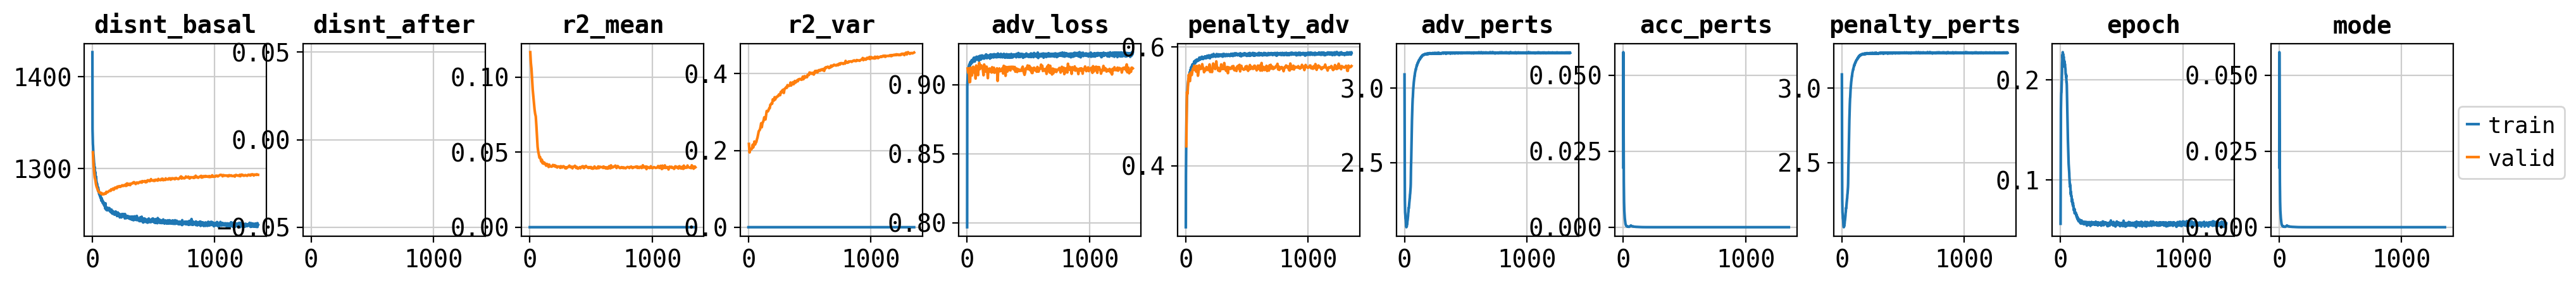

In [14]:
cpa.pl.plot_history(model)

If you already trained CPA, you can restore model weights by running the following cell:

In [15]:
# model = cpa.CPA.load(dir_path='/home/mohsen/projects/cpa/lightning_logs/combo_rdkit/', 
#                      adata=adata, use_gpu=True)

## Latent space UMAP visualization

Here, we visualize the latent representations of all cells. We computed basal and final latent representations with `model.get_latent_representation` function. The function will return a python dictionary as output with the following keys:

- `latent_basal`: Basal latent representation of the cells (before perturbation) as anndata object
- `latent_after`: Final latent representation of the cells (after perturbation) as anndata object
- `latent_corrected`: Batch-corrected (if `batch_key` was provided when calling `setup_anndata`) latent representation of the cells (after perturbation) as anndata object

In [16]:
latent_outputs = model.get_latent_representation(adata, batch_size=1024)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 62/62 [00:02<00:00, 23.61it/s]


In [17]:
sc.settings.verbosity = 3

In [18]:
latent_basal_adata = latent_outputs['latent_basal']
latent_adata = latent_outputs['latent_after']

In [19]:
sc.pp.neighbors(latent_basal_adata)
sc.tl.umap(latent_basal_adata)

computing neighbors
         Falling back to preprocessing with `sc.pp.pca` and default params.
computing PCA
    with n_comps=50
    finished (0:00:00)
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:03:03)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:31)


In [20]:
latent_basal_adata

AnnData object with n_obs × n_vars = 63378 × 64
    obs: 'ncounts', 'well', 'plate', 'cell_line', 'replicate', 'time', 'dose_value', 'pathway1', 'pathway2', 'perturbation', 'target', 'pathway', 'dose_unit', 'celltype', 'disease', 'tissue_type', 'organism', 'perturbation_type', 'ngenes', 'percent_mito', 'percent_ribo', 'nperts', 'chembl-ID', 'condition', 'condition_ID', 'control', 'cell_type', 'smiles_rdkit', 'source', 'sample', 'Size_Factor', 'n.umi', 'RT_well', 'Drug1', 'Drug2', 'Well', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden', 'split', 'condition_old', 'pert_type', 'batch', 'split_1ct_MEC', 'split_2ct_MEC', 'split_3ct_MEC', 'batch_cov', 'batch_cov_cond', 'log_dose', 'cov_drug_dose', 'CPA_cat', 'CPA_CHEMBL504', '_scvi_condition_ID', '_scvi_cell_type', '_scvi_CPA_cat'
    uns: 'neighbors', 'umap'
    obsm: 'X_pca', 'X_umap'
    obsp: 'distances', 'connectivities'

### Basal Latent

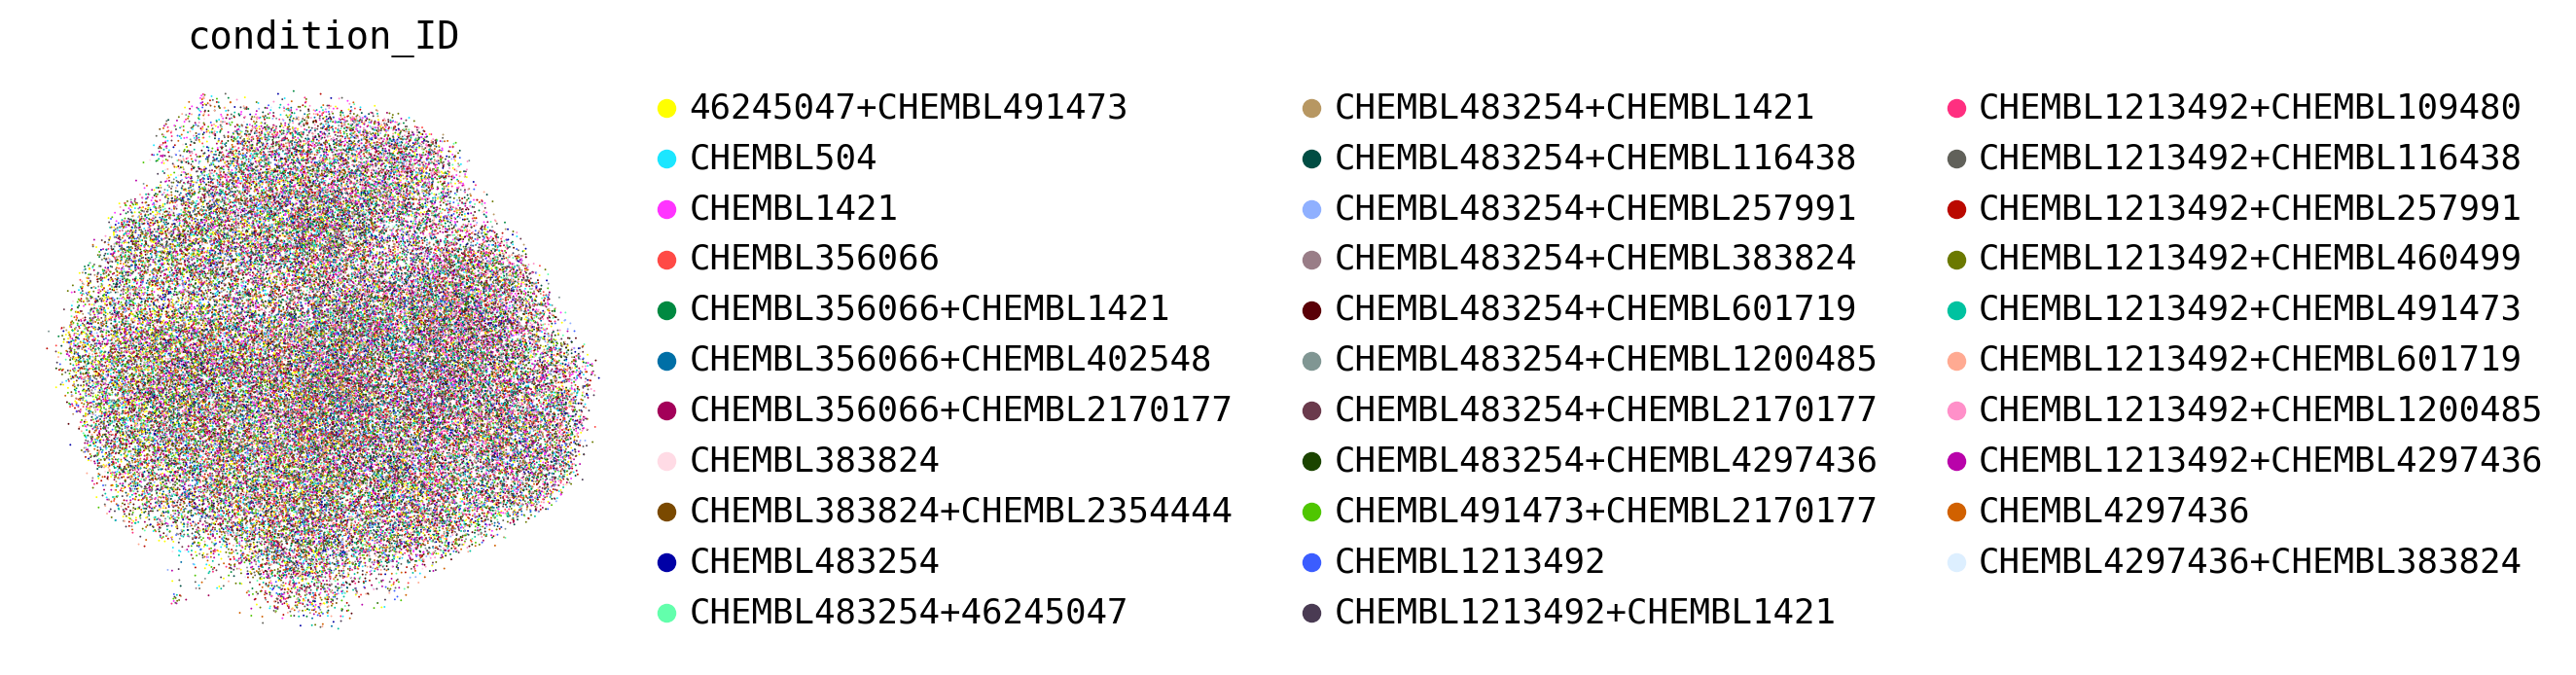

In [21]:
sc.pl.umap(latent_basal_adata, color=['condition_ID'], frameon=False, wspace=0.2)

In [22]:
sc.pp.neighbors(latent_adata)
sc.tl.umap(latent_adata)

computing neighbors
         Falling back to preprocessing with `sc.pp.pca` and default params.
computing PCA
    with n_comps=50
    finished (0:00:00)
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:08)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:34)


### Final Latent

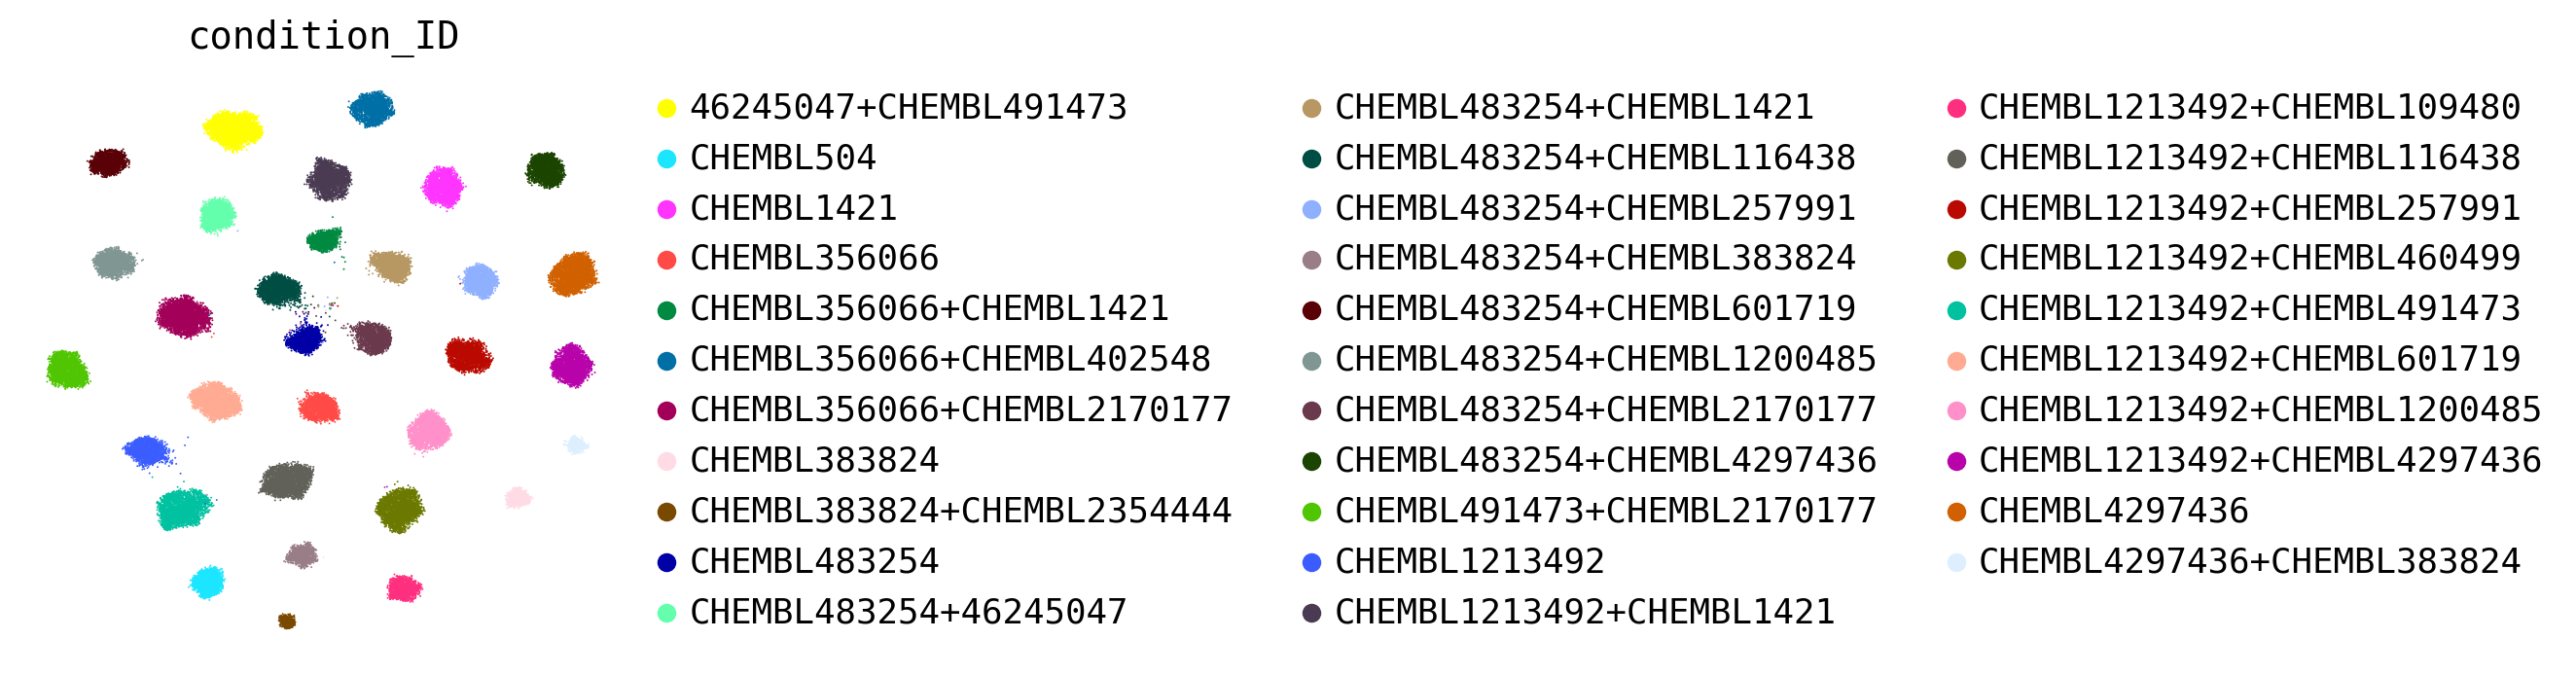

In [23]:
sc.pl.umap(latent_adata, color=['condition_ID'], frameon=False, wspace=0.2)

Next, we will evaluate model's prediction performance on whole dataset including OOD (test) cells.

In [24]:
model.predict(adata, batch_size=1024)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 62/62 [00:05<00:00, 11.28it/s]


In [25]:
import numpy as np
import pandas as pd
from sklearn.metrics import r2_score
from collections import defaultdict
from tqdm import tqdm

n_top_degs = [10, 20, 50, None] # None means all genes

results = defaultdict(list)
ctrl_adata = adata[adata.obs['condition_ID'] == 'CHEMBL504'].copy()
for cat in tqdm(adata.obs['cov_drug_dose'].unique()):
    if 'CHEMBL504' not in cat:
        cat_adata = adata[adata.obs['cov_drug_dose'] == cat].copy()

        deg_cat = f'{cat}'
        deg_list = adata.uns['rank_genes_groups_cov'][deg_cat]
        
        x_true = cat_adata.layers['counts'].toarray()
        x_pred = cat_adata.obsm['CPA_pred']
        x_ctrl = ctrl_adata.layers['counts'].toarray()

        x_true = np.log1p(x_true)
        x_pred = np.log1p(x_pred)
        x_ctrl = np.log1p(x_ctrl)

        for n_top_deg in n_top_degs:
            if n_top_deg is not None:
                degs = np.where(np.isin(adata.var_names, deg_list[:n_top_deg]))[0]
            else:
                degs = np.arange(adata.n_vars)
                n_top_deg = 'all'
                
            x_true_deg = x_true[:, degs]
            x_pred_deg = x_pred[:, degs]
            x_ctrl_deg = x_ctrl[:, degs]
            
            r2_mean_deg = r2_score(x_true_deg.mean(0), x_pred_deg.mean(0))
            r2_var_deg = r2_score(x_true_deg.var(0), x_pred_deg.var(0))

            r2_mean_lfc_deg = r2_score(x_true_deg.mean(0) - x_ctrl_deg.mean(0), x_pred_deg.mean(0) - x_ctrl_deg.mean(0))
            r2_var_lfc_deg = r2_score(x_true_deg.var(0) - x_ctrl_deg.var(0), x_pred_deg.var(0) - x_ctrl_deg.var(0))

            cov, cond, dose = cat.split('_')
            
            results['cell_type'].append(cov)
            results['condition'].append(cond)
            results['dose'].append(dose)
            results['n_top_deg'].append(n_top_deg)
            results['r2_mean_deg'].append(r2_mean_deg)
            results['r2_var_deg'].append(r2_var_deg)
            results['r2_mean_lfc_deg'].append(r2_mean_lfc_deg)
            results['r2_var_lfc_deg'].append(r2_var_lfc_deg)

df = pd.DataFrame(results)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:15<00:00,  2.12it/s]


In [26]:
df[df['n_top_deg'] == 20]

cell_type                    condition     dose n_top_deg  r2_mean_deg  \
1        A549                 CHEMBL483254      3.0        20     0.943252   
5        A549   CHEMBL491473+CHEMBL2170177  3.0+3.0        20     0.953437   
9        A549   CHEMBL1213492+CHEMBL257991  3.0+3.0        20     0.815992   
13       A549        CHEMBL483254+46245047  3.0+3.0        20     0.948573   
17       A549   CHEMBL483254+CHEMBL2170177  3.0+3.0        20     0.944003   
21       A549                 CHEMBL356066      3.0        20     0.933226   
25       A549   CHEMBL356066+CHEMBL2170177  3.0+3.0        20     0.943791   
29       A549   CHEMBL483254+CHEMBL1200485  3.0+3.0        20     0.951563   
33       A549   CHEMBL1213492+CHEMBL491473  3.0+3.0        20     0.607602   
37       A549                CHEMBL1213492      3.0        20     0.845446   
41       A549    CHEMBL356066+CHEMBL402548  3.0+3.0        20     0.748116   
45       A549      CHEMBL483254+CHEMBL1421  3.0+3.0        20     0.934773   
49       A549   CHEMBL1213492+CHEMBL109480  3.0+3.0        20     0.706345   
53       A549   CHEMBL1213492+CHEMBL460499  3.0+3.0        20     0.863053   
57       A549   CHEMBL483254+CHEMBL4297436  3.0+3.0        20     0.942252   
61       A549    CHEMBL483254+CHEMBL257991  3.0+3.0        20     0.940087   
65       A549    CHEMBL483254+CHEMBL601719  3.0+3.0        20     0.943840   
69       A549   CHEMBL383824+CHEMBL2354444  3.0+3.0        20     0.936724   
73       A549  CHEMBL1213492+CHEMBL4297436  3.0+3.0        20     0.792289   
77       A549  CHEMBL1213492+CHEMBL1200485  3.0+3.0        20     0.931320   
81       A549    CHEMBL483254+CHEMBL383824  3.0+3.0        20     0.496878   
85       A549                 CHEMBL383824      3.0        20     0.896525   
89       A549    CHEMBL483254+CHEMBL116438  3.0+3.0        20     0.950202   
93       A549     CHEMBL1213492+CHEMBL1421  3.0+3.0        20     0.842568   
97       A549   CHEMBL4297436+CHEMBL383824  3.0+3.0        20     0.888726   
101      A549      CHEMBL356066+CHEMBL1421  3.0+3.0        20     0.901944   
105      A549                CHEMBL4297436      3.0        20     0.728050   
109      A549   CHEMBL1213492+CHEMBL116438  3.0+3.0        20     0.884812   
113      A549   CHEMBL1213492+CHEMBL601719  3.0+3.0        20     0.810477   
117      A549        46245047+CHEMBL491473  3.0+3.0        20     0.875358   
121      A549                   CHEMBL1421      3.0        20     0.936153   

     r2_var_deg  r2_mean_lfc_deg  r2_var_lfc_deg  
1      0.222424         0.985652        0.758756  
5     -0.723978         0.345032      -19.256924  
9     -2.668683         0.308896       -6.126473  
13     0.245916         0.985587        0.741571  
17     0.019561         0.982641        0.619355  
21    -0.177728         0.977254        0.643084  
25     0.077367         0.982595        0.729290  
29     0.166435         0.985437        0.678770  
33    -1.442659         0.467476       -3.483045  
37    -3.124852         0.555419       -1.616240  
41    -0.468033         0.923252        0.609934  
45    -0.018929         0.982338        0.645029  
49    -1.185113         0.873071       -1.703947  
53    -3.360452         0.682881       -4.661797  
57     0.051656         0.983361        0.665030  
61     0.079230         0.983258        0.683227  
65    -0.008598         0.981825        0.608500  
69    -1.103101         0.957802        0.116940  
73    -1.255896         0.387688       -1.011227  
77    -0.043086         0.966058        0.680356  
81    -1.205903         0.835792        0.192209  
85    -2.160942         0.858206       -1.138908  
89     0.287852         0.986677        0.770033  
93    -3.738260         0.780868       -3.050616  
97    -1.714776         0.927265       -0.432541  
101    0.031103         0.975665        0.713307  
105   -3.757220        -1.039214      -15.514841  
109   -3.038191         0.601723       -5.172740  
113   -0.981200         0.77

A549_CHEMBL483254_3.0 (1578, 5000)
Top 20 DEGs var:  0.9432570119362333
All genes var:  0.2383808579912715


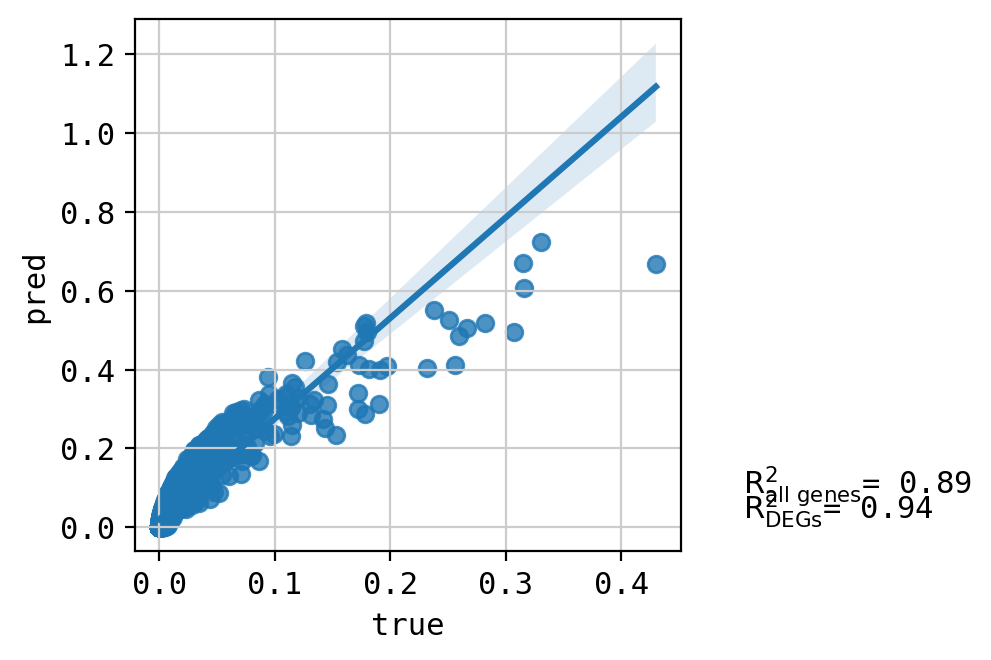

A549_CHEMBL491473+CHEMBL2170177_3.0+3.0 (2161, 5000)
Top 20 DEGs var:  0.9534399036528307
All genes var:  0.32357108908961274


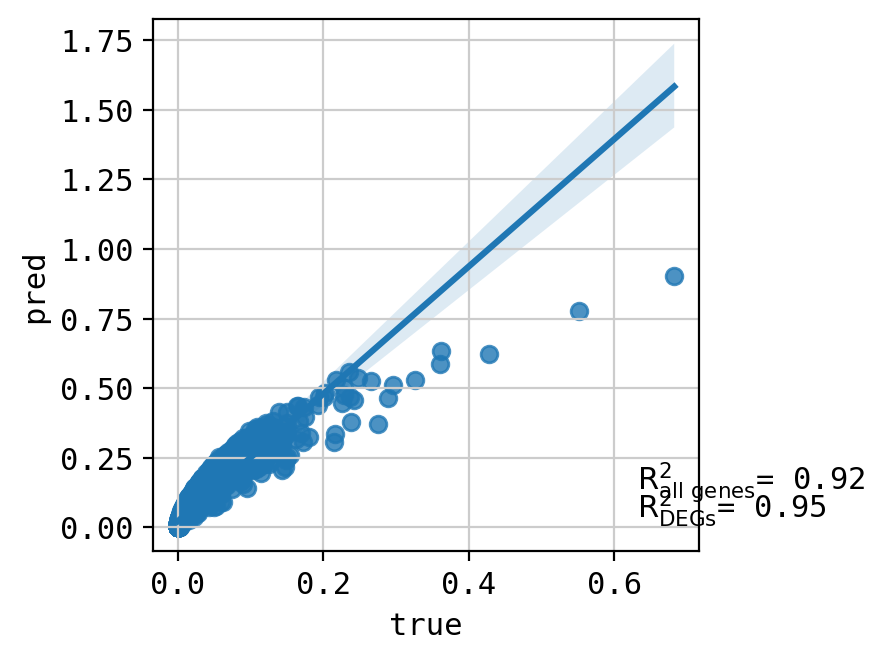

A549_CHEMBL1213492+CHEMBL257991_3.0+3.0 (2260, 5000)
Top 20 DEGs var:  0.8160014574452075
All genes var:  0.27984262715152175


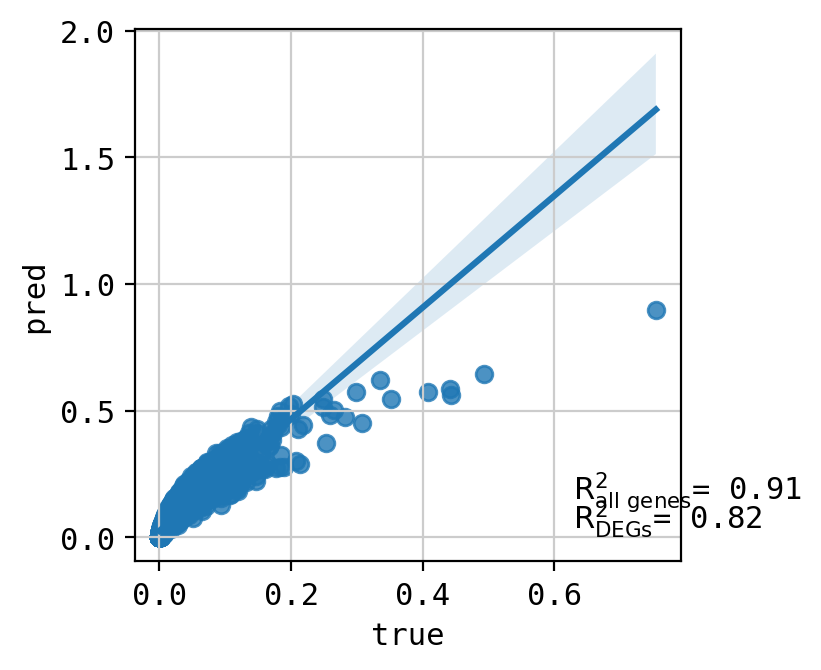

A549_CHEMBL483254+46245047_3.0+3.0 (1889, 5000)
Top 20 DEGs var:  0.9485761406990977
All genes var:  0.3656485031352644


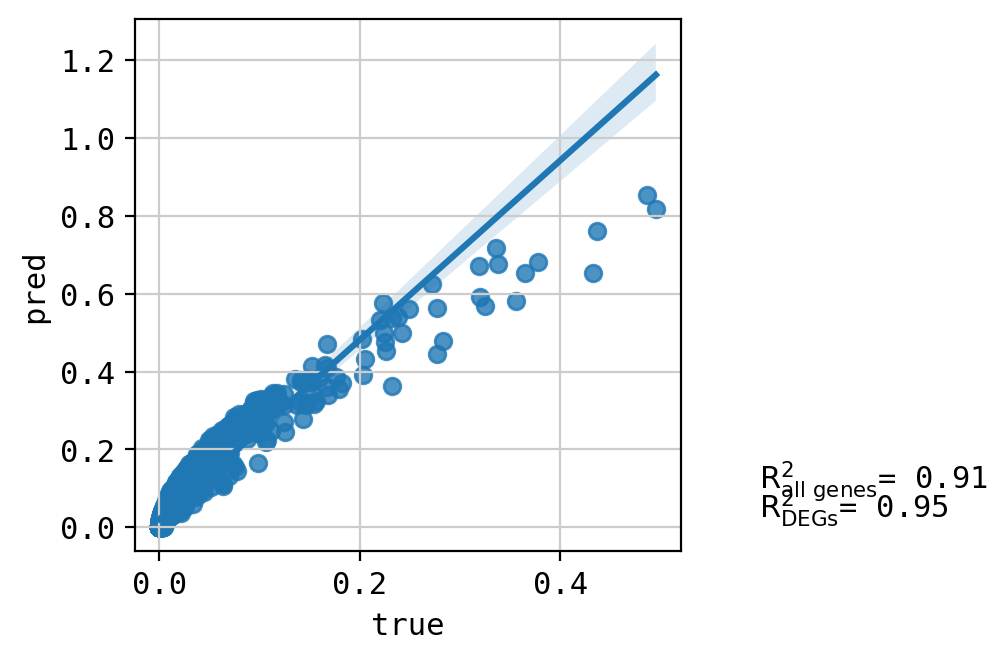

A549_CHEMBL483254+CHEMBL2170177_3.0+3.0 (1814, 5000)
Top 20 DEGs var:  0.9440058158529224
All genes var:  0.28778099233742227


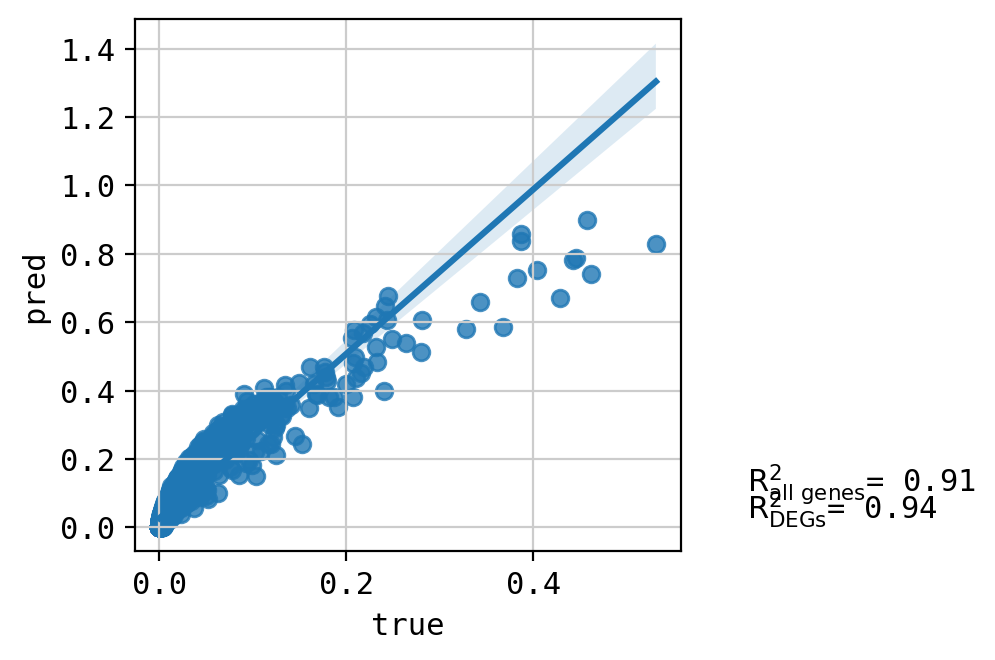

A549_CHEMBL356066_3.0 (1869, 5000)
Top 20 DEGs var:  0.9332284720946527
All genes var:  0.20723961915360356


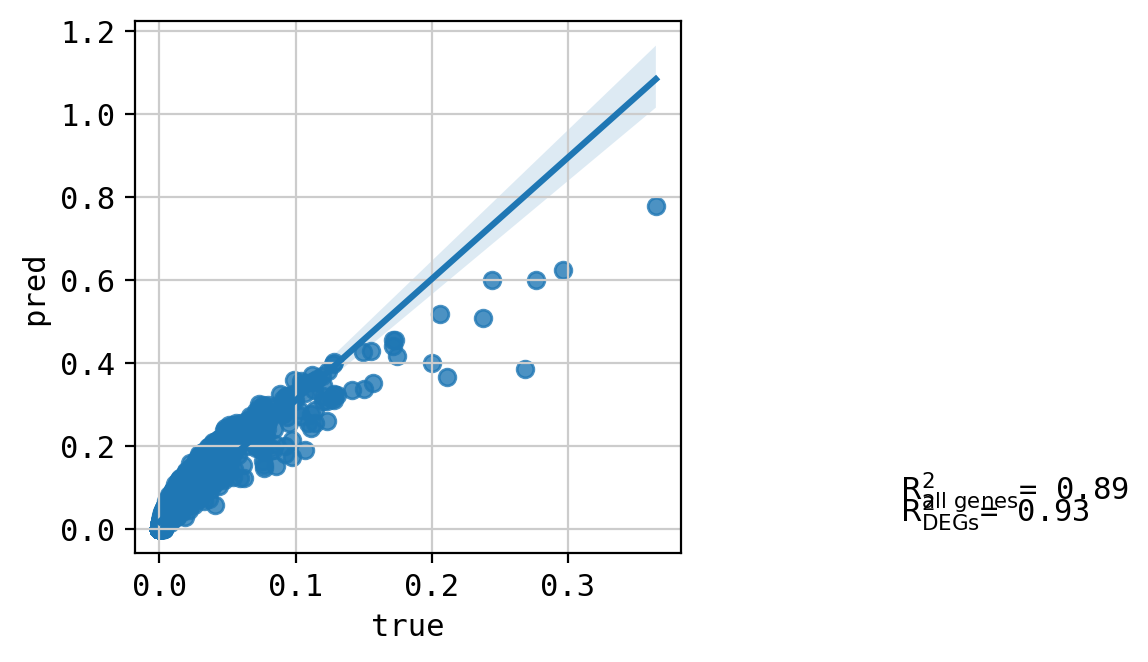

A549_CHEMBL356066+CHEMBL2170177_3.0+3.0 (3298, 5000)
Top 20 DEGs var:  0.9437920785334201
All genes var:  0.22203679591558112


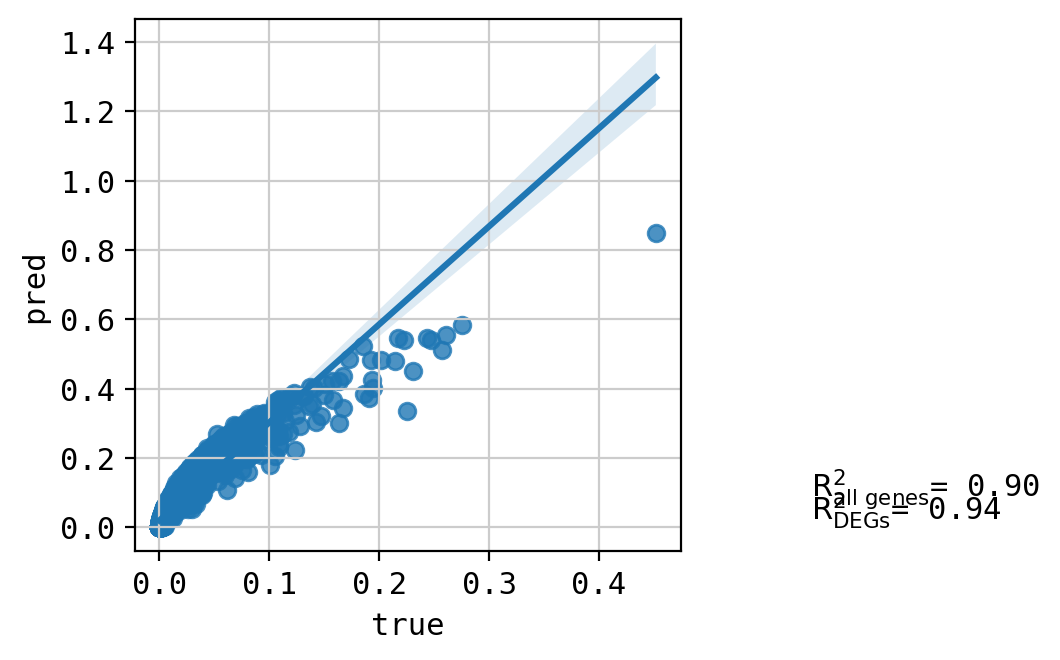

A549_CHEMBL483254+CHEMBL1200485_3.0+3.0 (2013, 5000)
Top 20 DEGs var:  0.9515651464946858
All genes var:  0.33489523506046215


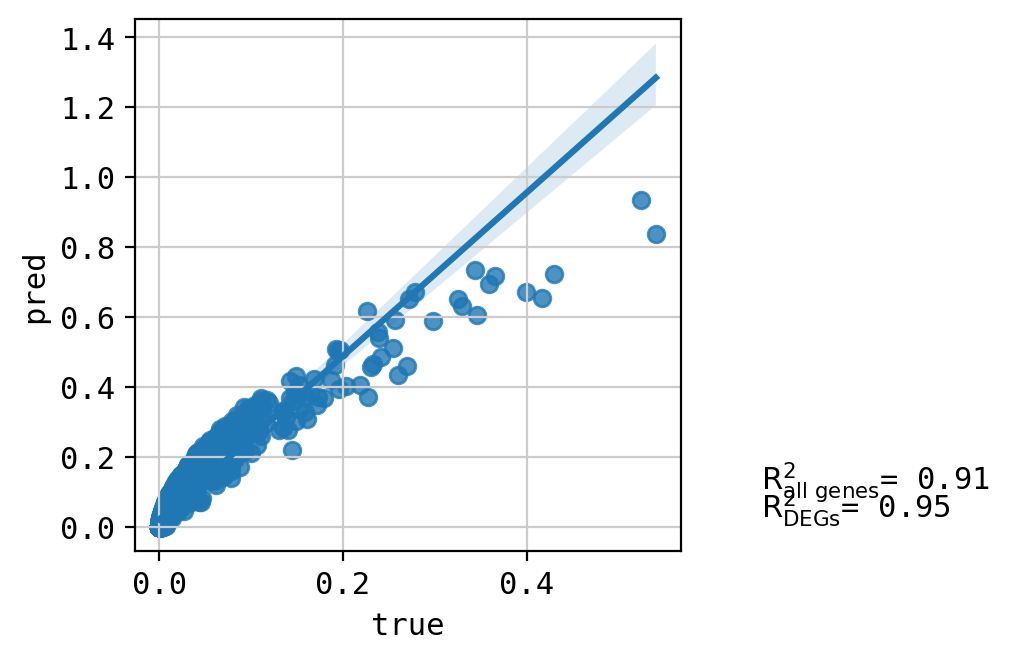

A549_CHEMBL1213492+CHEMBL491473_3.0+3.0 (2783, 5000)
Top 20 DEGs var:  0.6076002851215299
All genes var:  0.27443908963125596


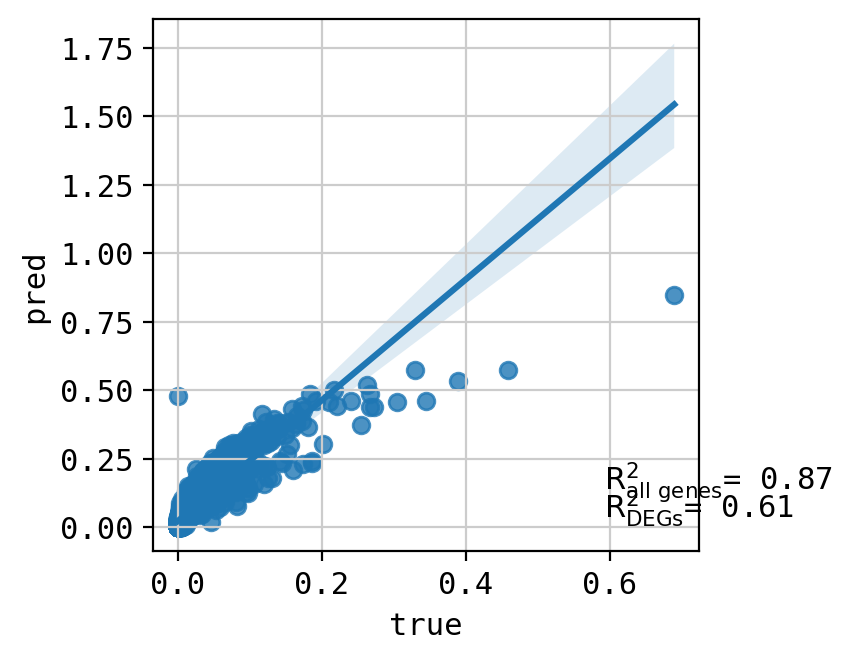

A549_CHEMBL1213492_3.0 (1682, 5000)
Top 20 DEGs var:  0.8454551331901641
All genes var:  0.24572231027227376


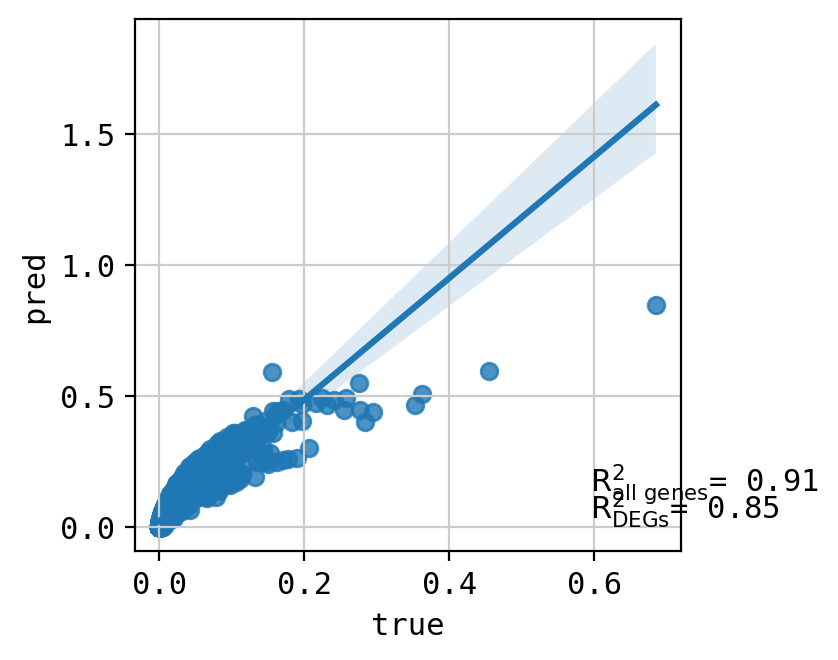

A549_CHEMBL356066+CHEMBL402548_3.0+3.0 (1939, 5000)
Top 20 DEGs var:  0.7481165747181706
All genes var:  0.12389914380865896


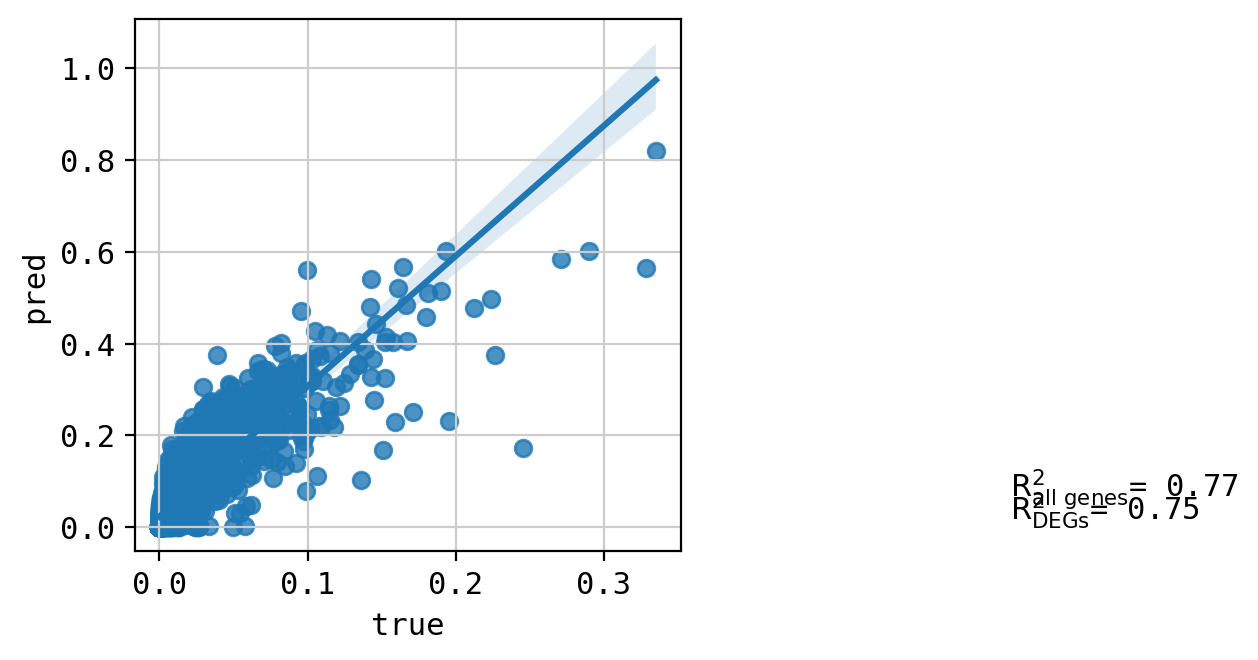

A549_CHEMBL483254+CHEMBL1421_3.0+3.0 (1955, 5000)
Top 20 DEGs var:  0.934776396223971
All genes var:  0.2366556337809702


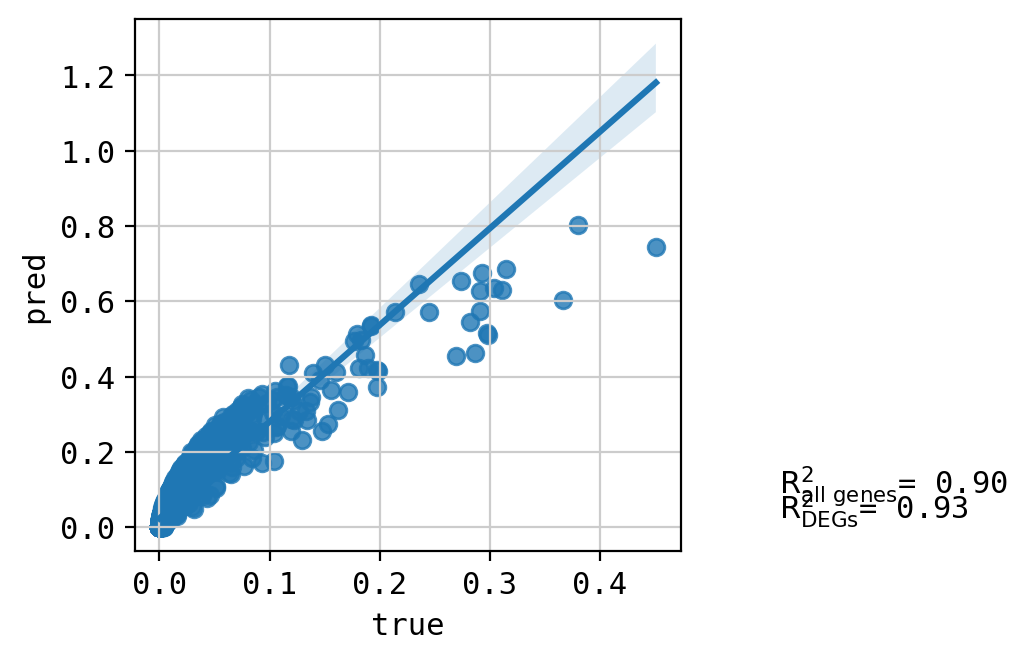

A549_CHEMBL1213492+CHEMBL109480_3.0+3.0 (1310, 5000)
Top 20 DEGs var:  0.706362704506477
All genes var:  0.3362485928159149


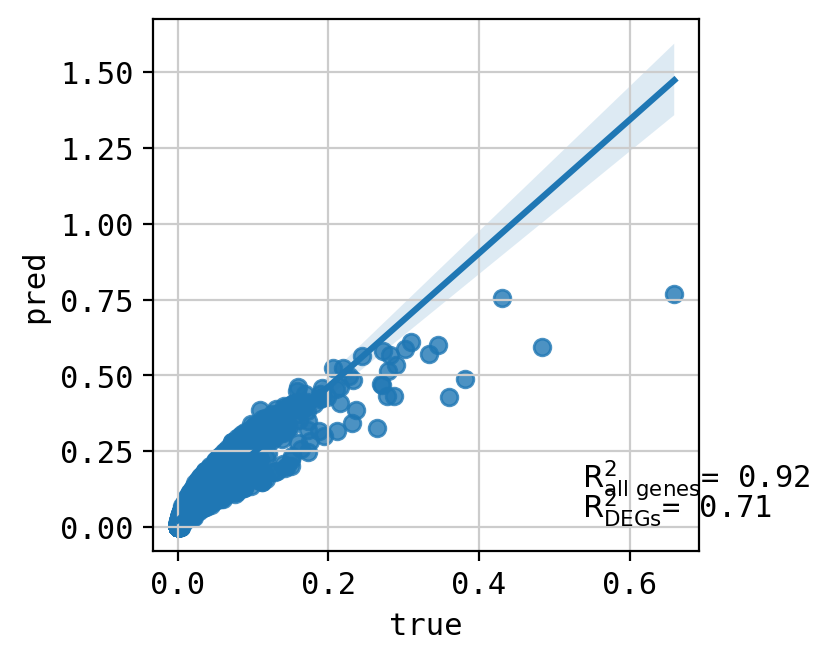

A549_CHEMBL1213492+CHEMBL460499_3.0+3.0 (2692, 5000)
Top 20 DEGs var:  0.863054790510513
All genes var:  0.23900141664137675


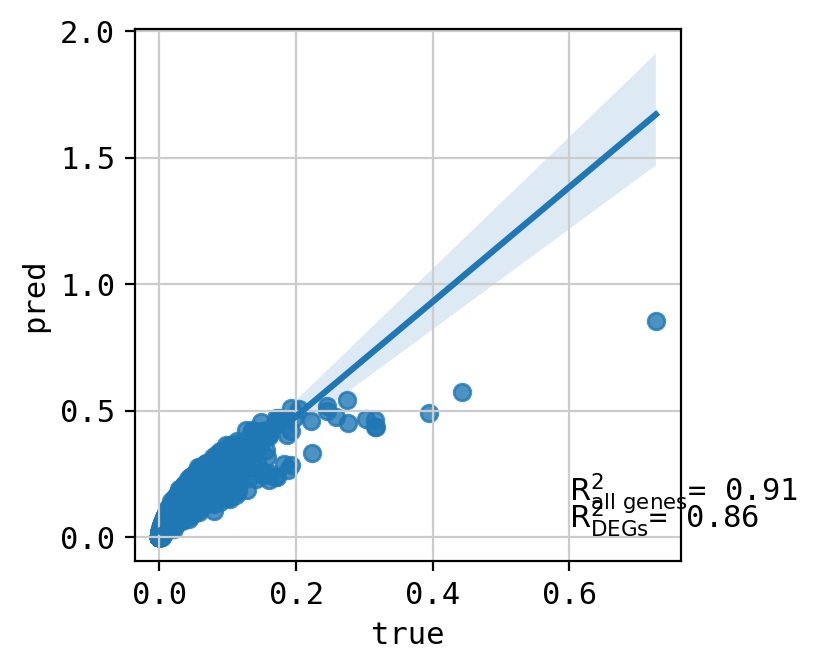

A549_CHEMBL483254+CHEMBL4297436_3.0+3.0 (1971, 5000)
Top 20 DEGs var:  0.9422541889114032
All genes var:  0.22341950424153467


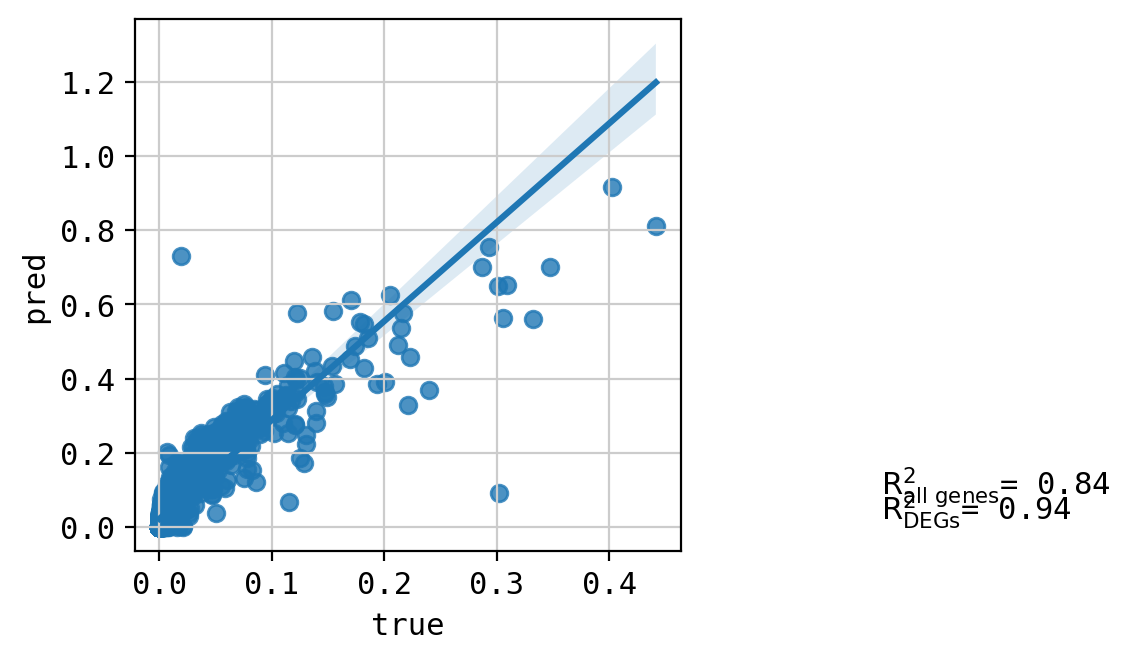

A549_CHEMBL483254+CHEMBL257991_3.0+3.0 (1826, 5000)
Top 20 DEGs var:  0.9400900790227729
All genes var:  0.24910902525384204


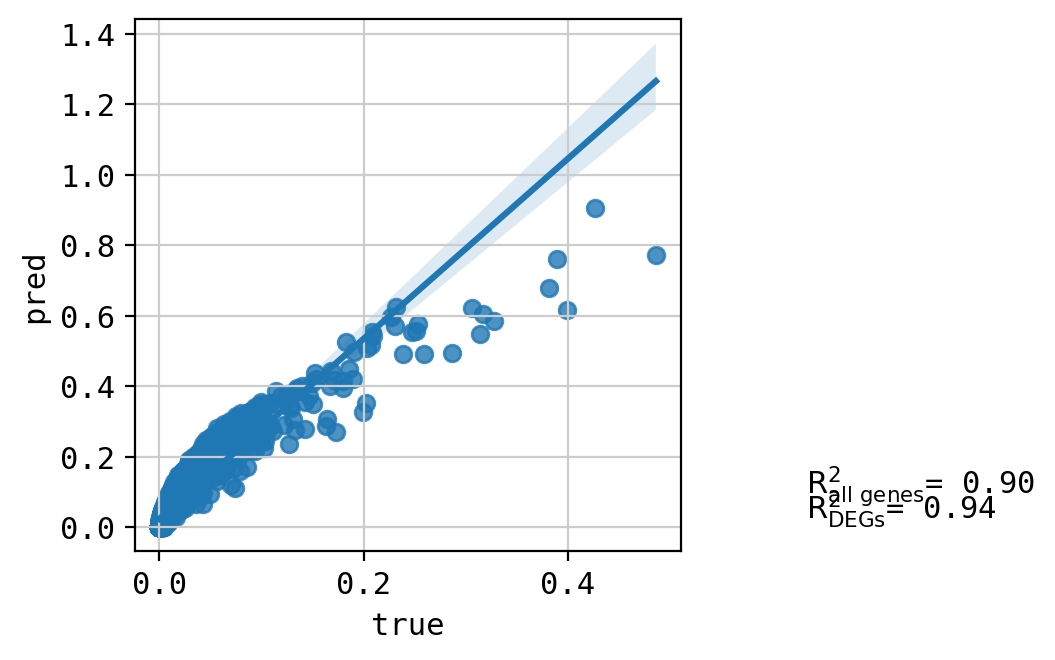

A549_CHEMBL483254+CHEMBL601719_3.0+3.0 (1641, 5000)
Top 20 DEGs var:  0.9438439375563483
All genes var:  0.2952641755499209


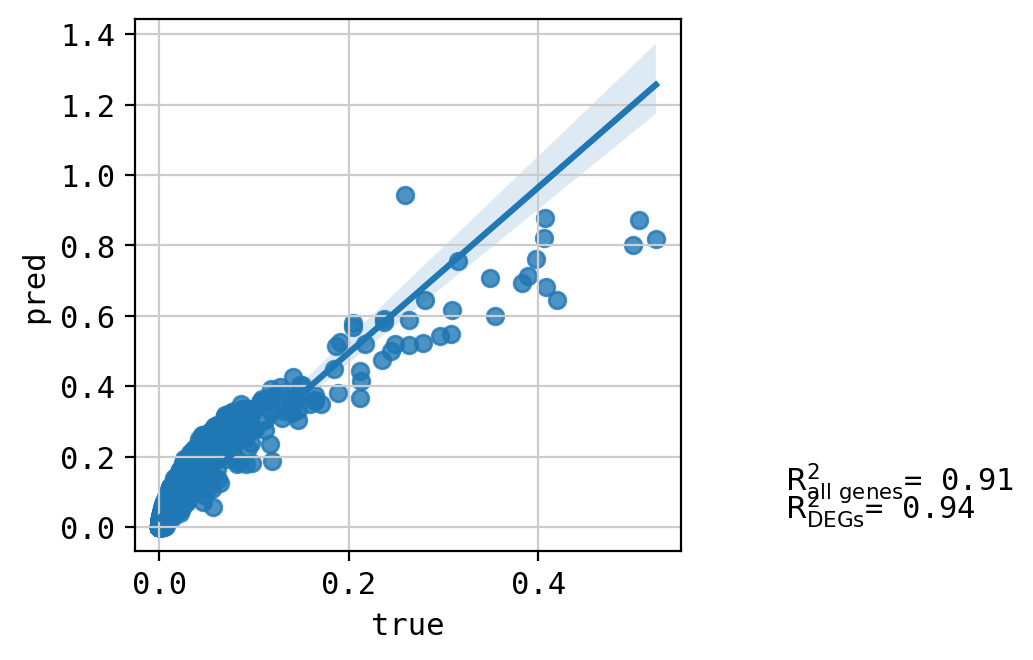

A549_CHEMBL383824+CHEMBL2354444_3.0+3.0 (476, 5000)
Top 20 DEGs var:  0.936723645221692
All genes var:  0.3553705779281776


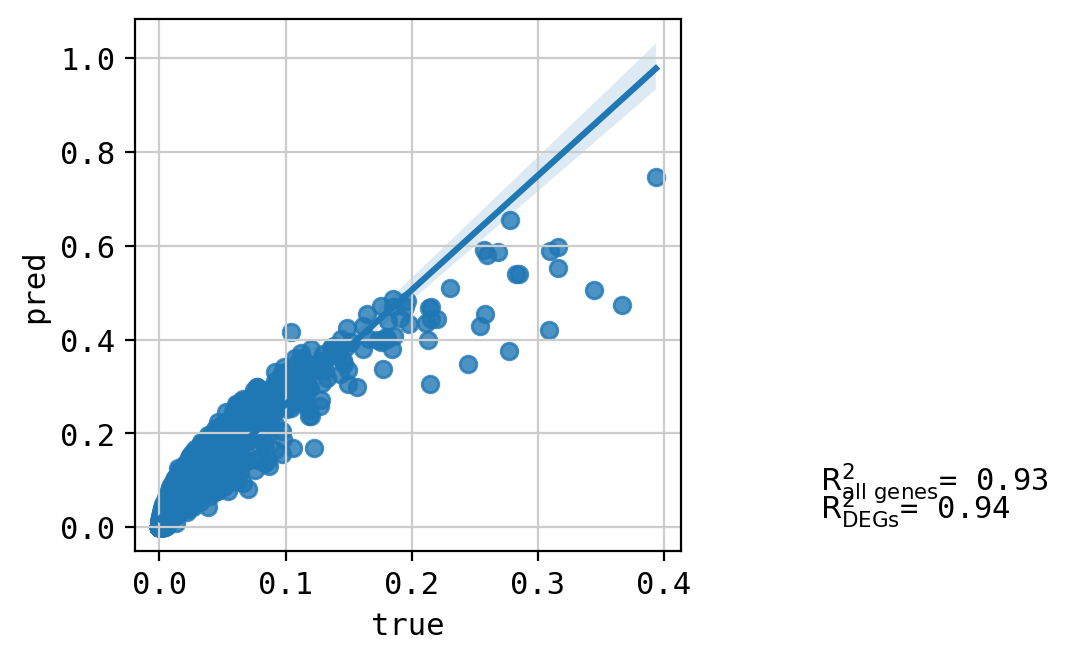

A549_CHEMBL1213492+CHEMBL4297436_3.0+3.0 (2353, 5000)
Top 20 DEGs var:  0.792297524159662
All genes var:  0.3107678007497654


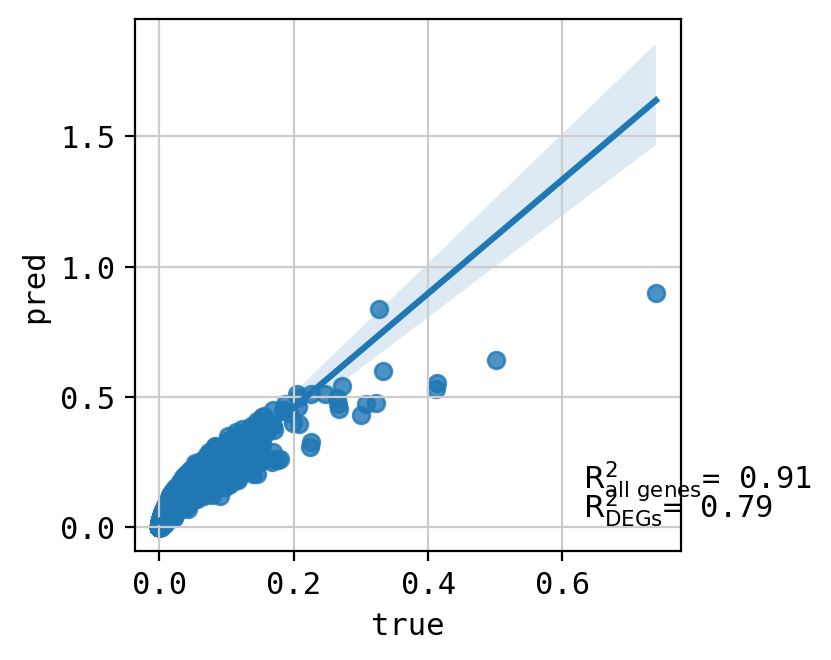

A549_CHEMBL1213492+CHEMBL1200485_3.0+3.0 (2734, 5000)
Top 20 DEGs var:  0.9313229171757604
All genes var:  0.17166578684608935


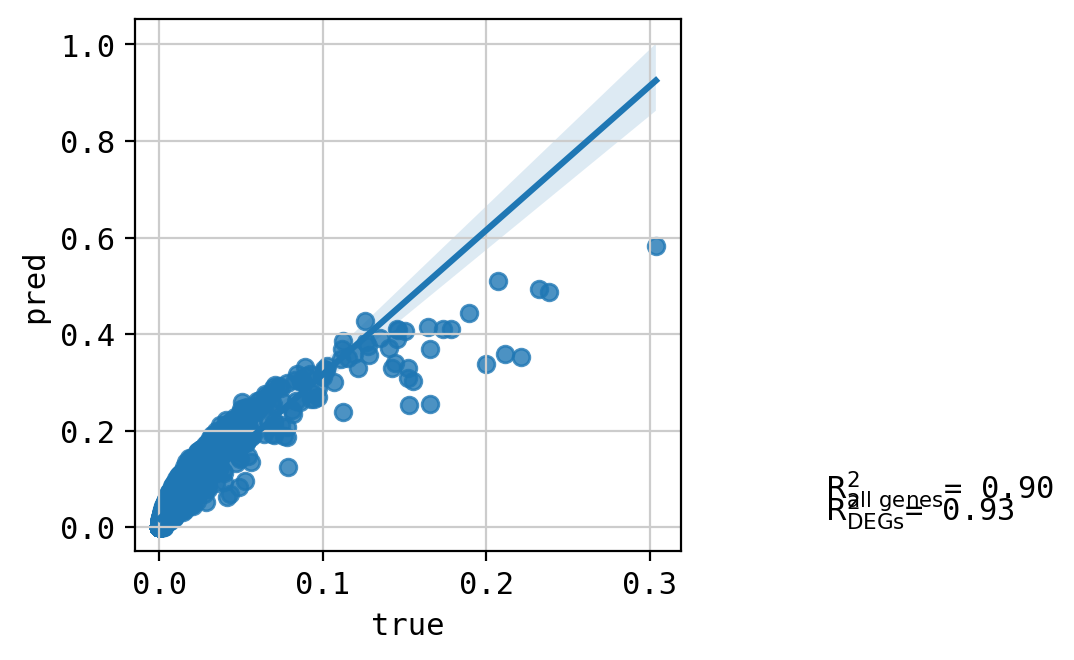

A549_CHEMBL483254+CHEMBL383824_3.0+3.0 (996, 5000)
Top 20 DEGs var:  0.4968727606901995
All genes var:  0.1787646931836686


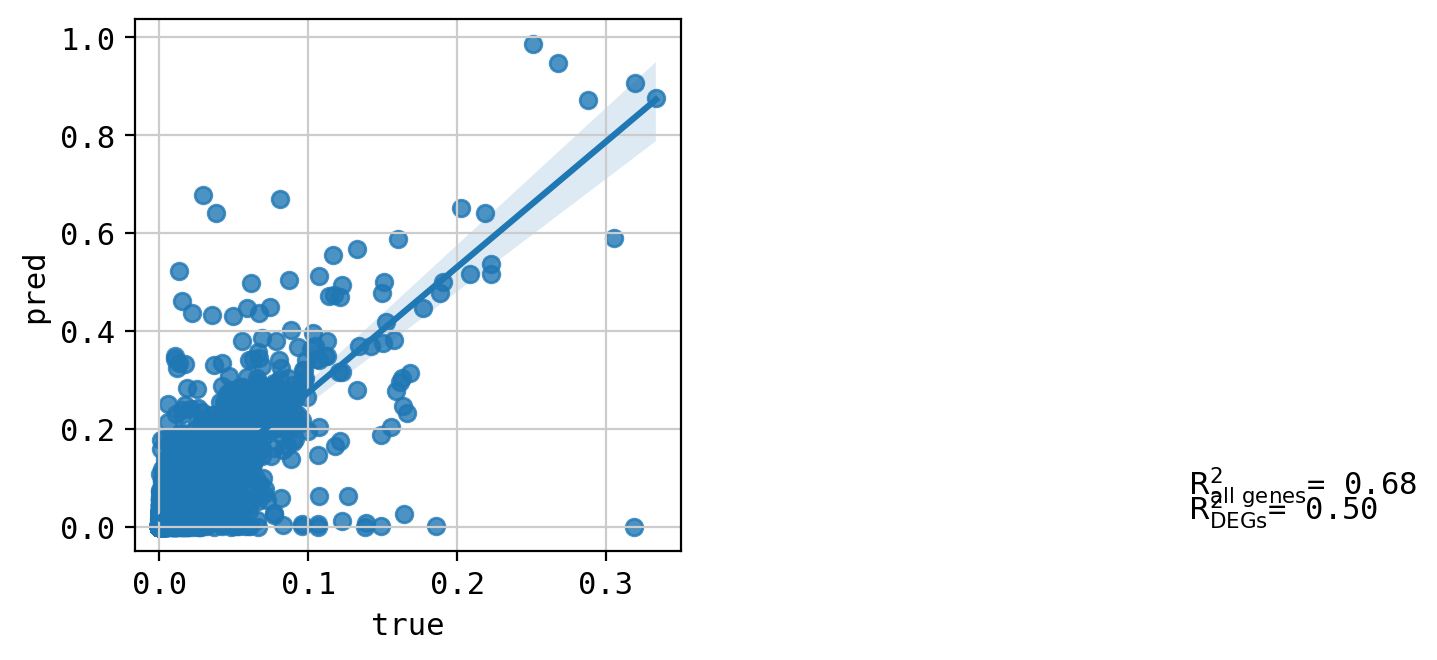

A549_CHEMBL383824_3.0 (758, 5000)
Top 20 DEGs var:  0.8965285137419556
All genes var:  0.3831937702713043


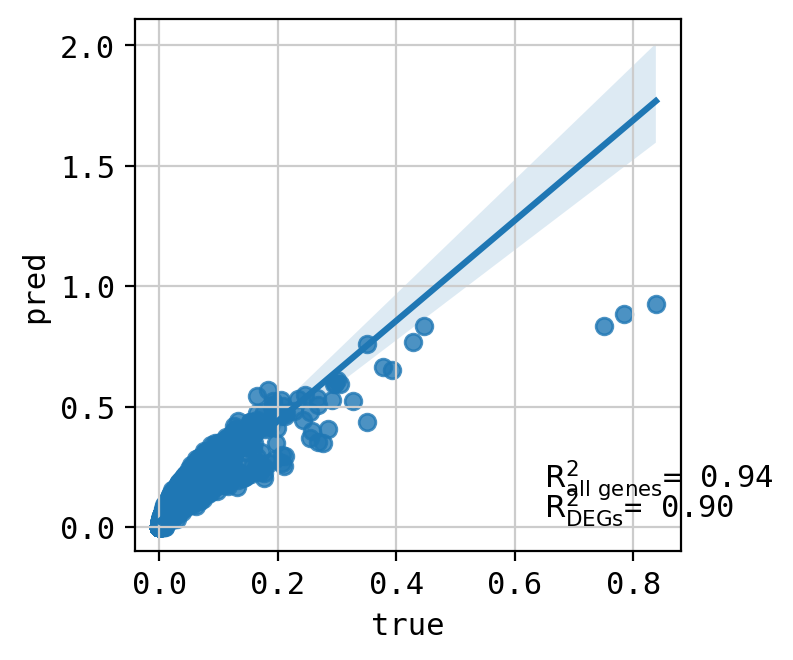

A549_CHEMBL483254+CHEMBL116438_3.0+3.0 (2244, 5000)
Top 20 DEGs var:  0.9502036607016588
All genes var:  0.26971633067733725


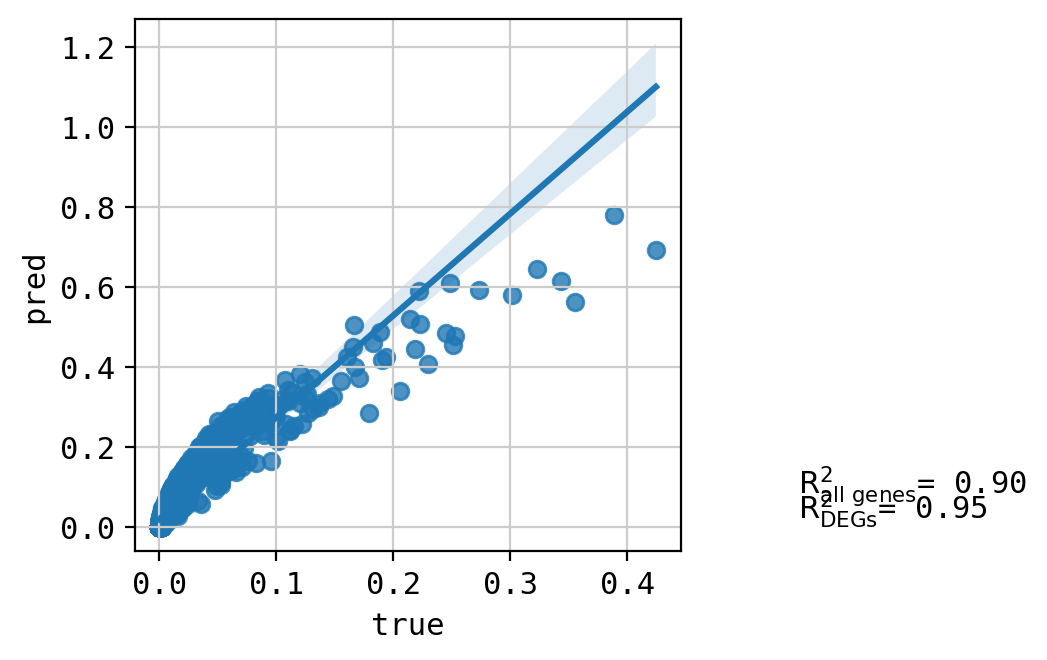

A549_CHEMBL1213492+CHEMBL1421_3.0+3.0 (2421, 5000)
Top 20 DEGs var:  0.8425749877700159
All genes var:  0.2750751945668547


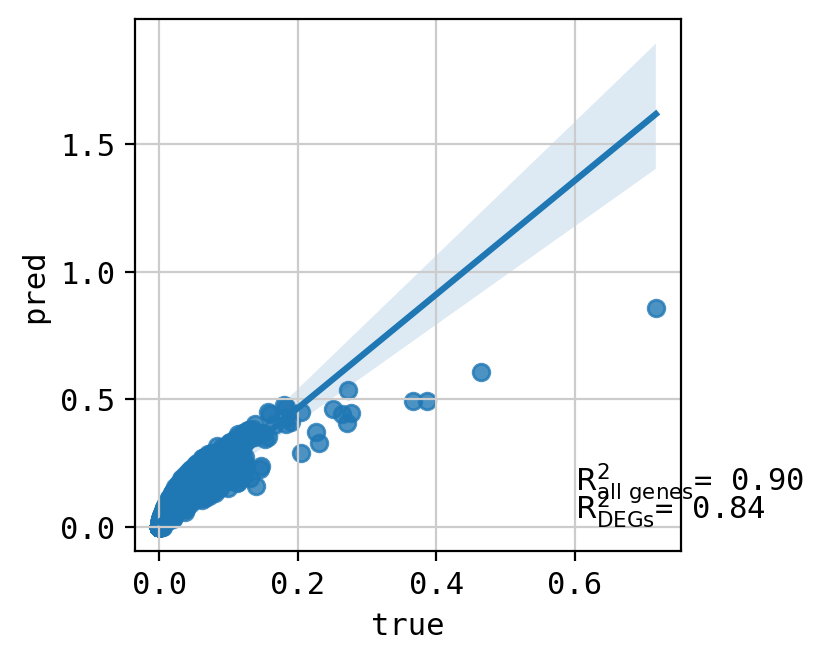

A549_CHEMBL4297436+CHEMBL383824_3.0+3.0 (520, 5000)
Top 20 DEGs var:  0.8887265210694321
All genes var:  0.21741516085853863


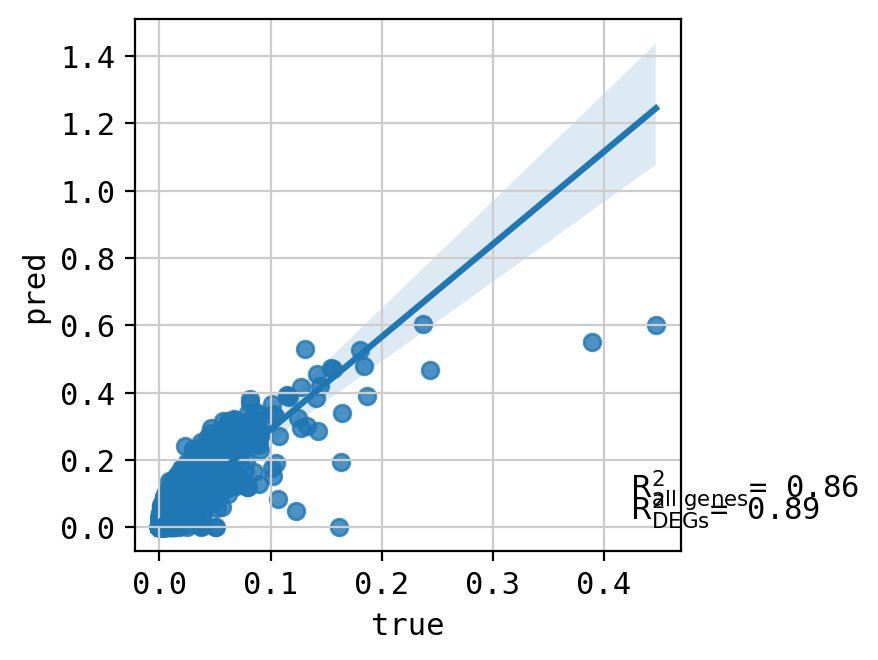

A549_CHEMBL356066+CHEMBL1421_3.0+3.0 (1231, 5000)
Top 20 DEGs var:  0.9019485977562606
All genes var:  0.19927103640546096


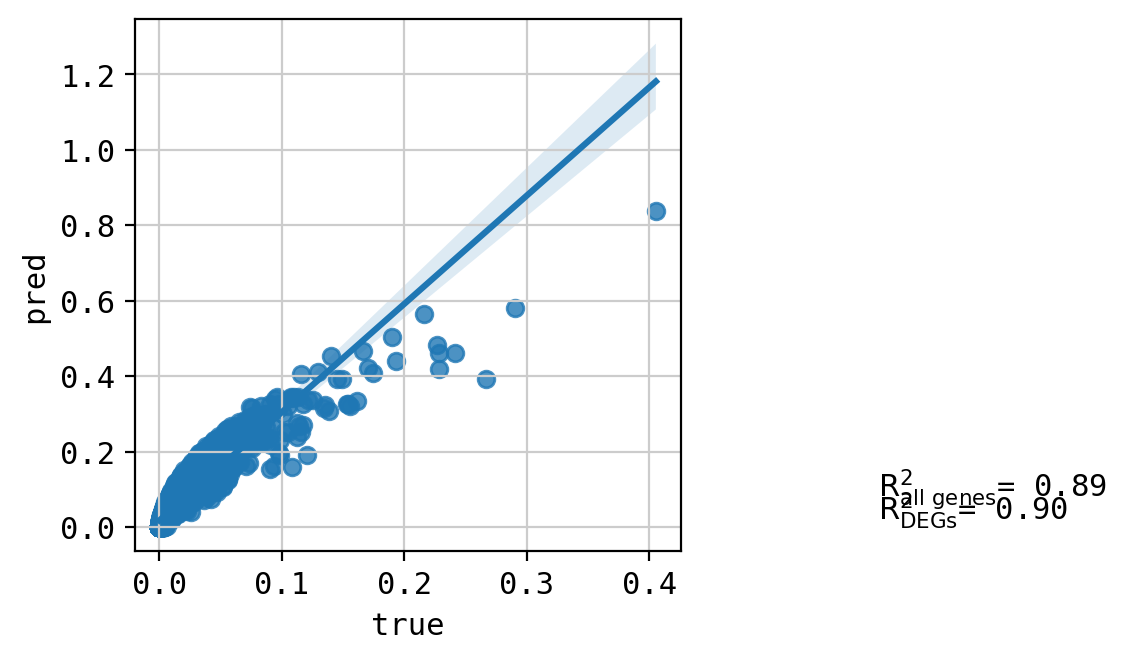

A549_CHEMBL4297436_3.0 (2756, 5000)
Top 20 DEGs var:  0.7280733638487724
All genes var:  0.28689414242694167


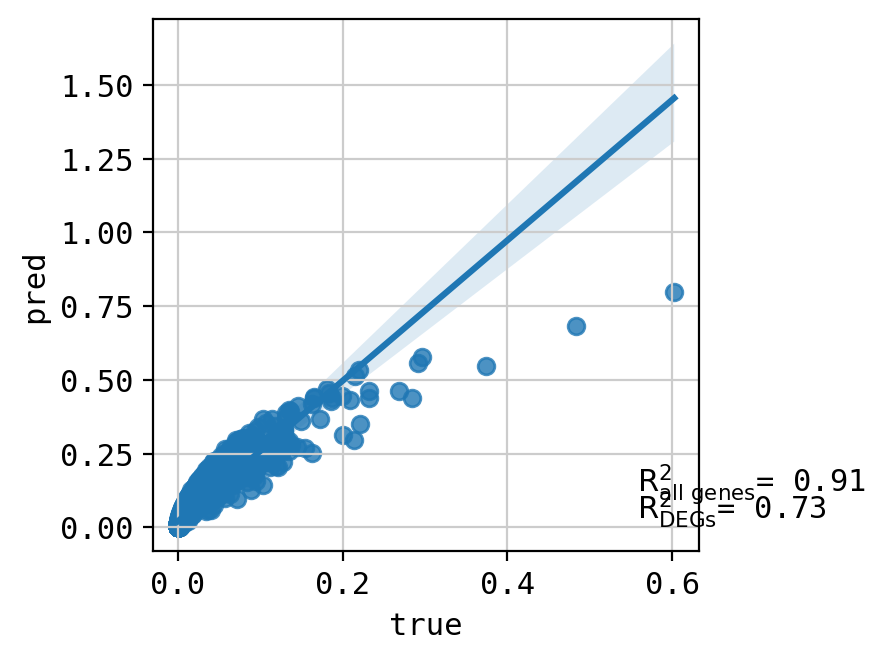

A549_CHEMBL1213492+CHEMBL116438_3.0+3.0 (2736, 5000)
Top 20 DEGs var:  0.8848140790799369
All genes var:  0.29790094480564633


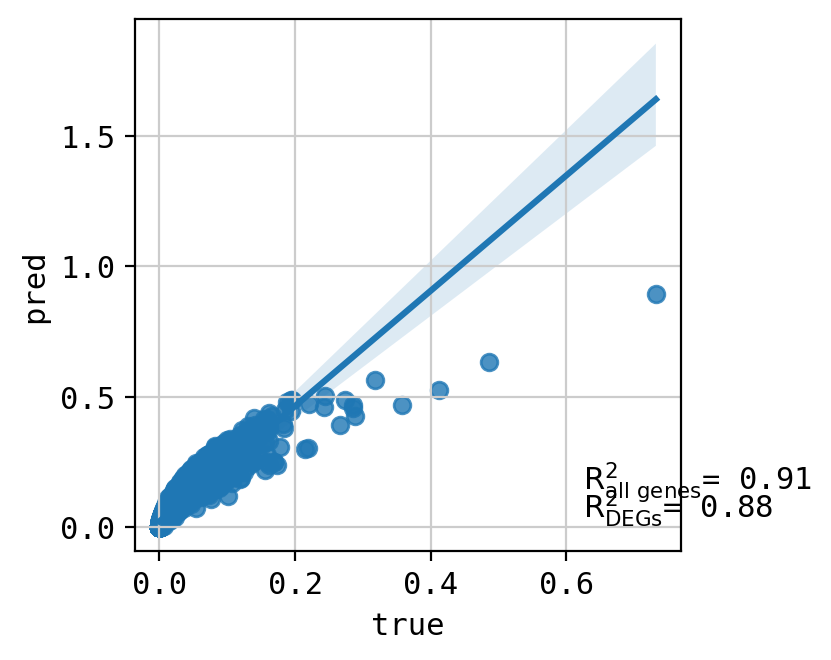

A549_CHEMBL1213492+CHEMBL601719_3.0+3.0 (2662, 5000)
Top 20 DEGs var:  0.8104838141770024
All genes var:  0.26790973907234417


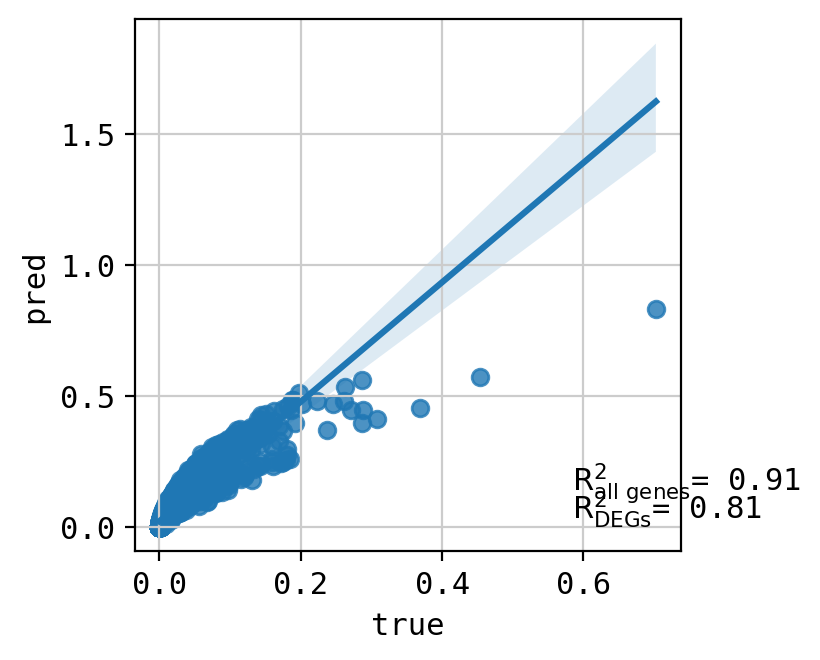

A549_46245047+CHEMBL491473_3.0+3.0 (3016, 5000)
Top 20 DEGs var:  0.8753626170879585
All genes var:  0.29425056709554254


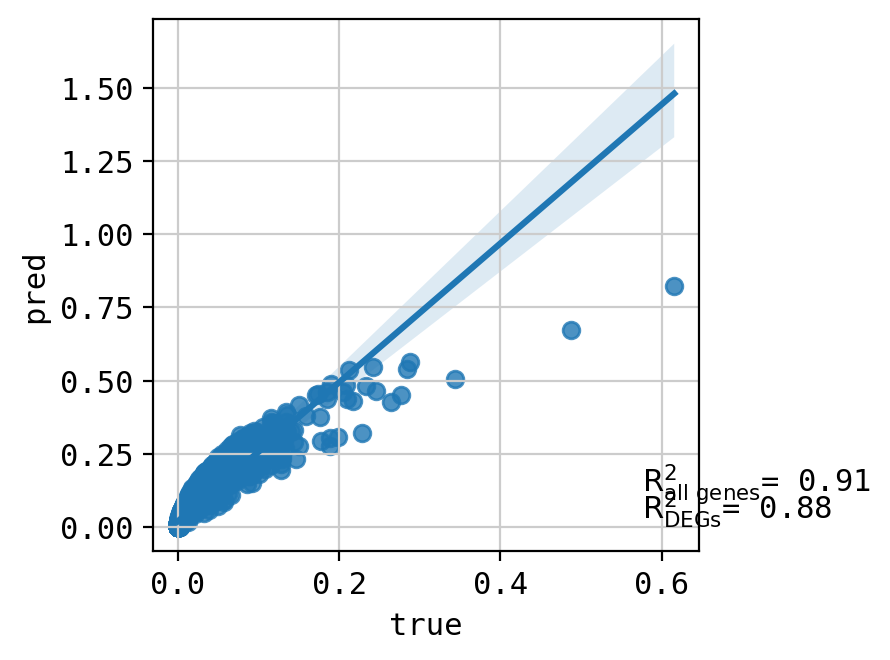

A549_CHEMBL1421_3.0 (2343, 5000)
Top 20 DEGs var:  0.9361548093504224
All genes var:  0.19595293836598193


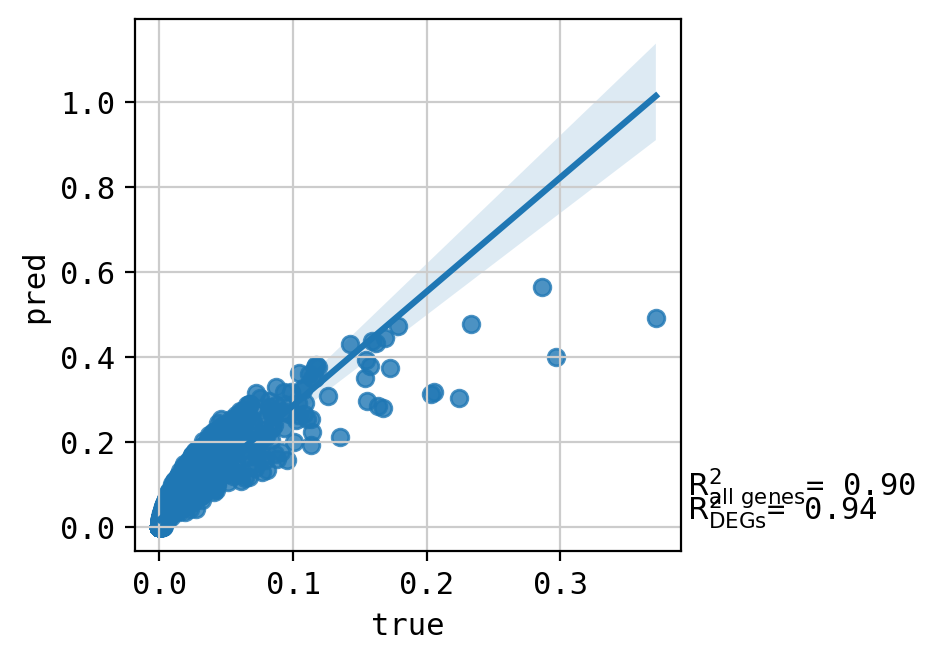

In [27]:
for cat in adata.obs["cov_drug_dose"].unique():
    if "CHEMBL504" not in cat:
        cat_adata = adata[adata.obs["cov_drug_dose"] == cat].copy()

        cat_adata.X = np.log1p(cat_adata.layers["counts"].A)
        cat_adata.obsm["CPA_pred"] = np.log1p(cat_adata.obsm["CPA_pred"])

        deg_list = adata.uns["rank_genes_groups_cov"][f'{cat}'][:20]

        print(cat, f"{cat_adata.shape}")
        cpa.pl.mean_plot(
            cat_adata,
            pred_obsm_key="CPA_pred",
            path_to_save=None,
            deg_list=deg_list,
            # gene_list=deg_list[:5],
            show=True,
            verbose=True,
        )

## Compert API for compatibility with scanpy

In [28]:
cpa_api = cpa.ComPertAPI(adata, model, 
                         de_genes_uns_key='rank_genes_groups_cov', 
                         pert_category_key='cov_drug_dose',
                         control_group='CHEMBL504',
                         )

In [29]:
cpa_plots = cpa.pl.CompertVisuals(cpa_api, fileprefix=None)

In [30]:
cpa_api.num_measured_points['train']

{'A549_46245047+CHEMBL491473_3.0+3.0': 2723,
 'A549_CHEMBL1213492+CHEMBL109480_3.0+3.0': 1175,
 'A549_CHEMBL1213492+CHEMBL116438_3.0+3.0': 2447,
 'A549_CHEMBL1213492+CHEMBL1200485_3.0+3.0': 2479,
 'A549_CHEMBL1213492+CHEMBL1421_3.0+3.0': 2158,
 'A549_CHEMBL1213492+CHEMBL257991_3.0+3.0': 2037,
 'A549_CHEMBL1213492+CHEMBL4297436_3.0+3.0': 2127,
 'A549_CHEMBL1213492+CHEMBL460499_3.0+3.0': 2425,
 'A549_CHEMBL1213492+CHEMBL601719_3.0+3.0': 2383,
 'A549_CHEMBL1213492_3.0': 1527,
 'A549_CHEMBL1421_3.0': 2133,
 'A549_CHEMBL356066+CHEMBL1421_3.0+3.0': 1124,
 'A549_CHEMBL356066+CHEMBL2170177_3.0+3.0': 2975,
 'A549_CHEMBL356066_3.0': 1679,
 'A549_CHEMBL383824+CHEMBL2354444_3.0+3.0': 421,
 'A549_CHEMBL383824_3.0': 690,
 'A549_CHEMBL4297436_3.0': 2491,
 'A549_CHEMBL483254+46245047_3.0+3.0': 1697,
 'A549_CHEMBL483254+CHEMBL116438_3.0+3.0': 2016,
 'A549_CHEMBL483254+CHEMBL1200485_3.0+3.0': 1810,
 'A549_CHEMBL483254+CHEMBL1421_3.0+3.0': 1762,
 'A549_CHEMBL483254+CHEMBL2170177_3.0+3.0': 1629,
 'A549_CH

In [31]:
drug_adata = cpa_api.get_pert_embeddings()
drug_adata.shape

(19, 64)

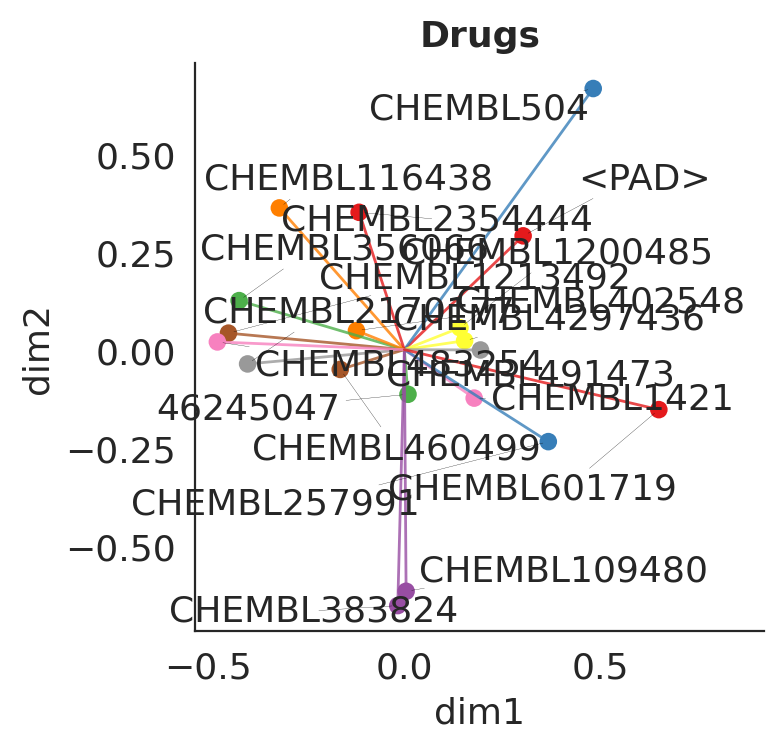

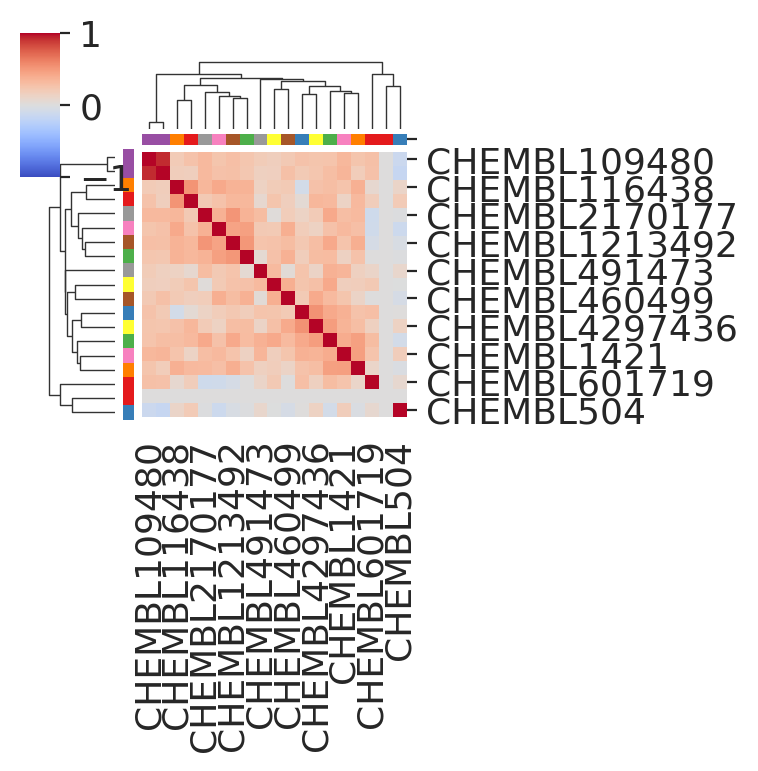

In [32]:
cpa_plots.plot_latent_embeddings(drug_adata.X, kind='perturbations', titlename='Drugs')